In [1]:
%load_ext autoreload
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import csv
import json
import os 
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import shutil
from importlib import reload
from IPython.display import Image, display, HTML
import matplotlib.gridspec as gridspec
import mpld3
import pprint 
pp = pprint.PrettyPrinter(indent=4)

In [3]:
import config
import utils

import raw_log_types
import results
import tasks
import task_results
from main import VbsVis
import plot

from constants import *

In [4]:
%autoreload 2

In [5]:
VbsVis.flush_cache()
vbs = VbsVis()

vbs.parse_team("SOMHunter", 
                  ["sh-patrik", "sh-vit"], 
                  verbose=True, 
                  rewrite=False, 
                  validate_fix=False,
                  generate_DRES=False
                 )
vbs.parse_team("CollageHunter", 
                  ["collage-jakub", "collage-premek"], 
                  verbose=True,
                  rewrite=False,  
                  validate_fix=False, 
                  generate_DRES=False
                 )
vbs.parse_team("LegacySOMHunter", 
                  ["legacy-tereza", "legacy-franta-tomas"], 
                  verbose=True, 
                  rewrite=False, 
                  validate_fix=False, 
                  generate_DRES=False
                 )

#VbsVis.help()

Error while deleting directory
%%% PARSING TASKS %%%
%%% Parsed 38 tasks. %%%
%%% DONE! %%%
%%% PARSING VERDICTS %%%
%%% DONE %%%
TEAM: SOMHunter

%%% PARSING %%%
---
+++ sh-patrik +++ 
DATA: ./data/sh-patrik 

	--- PARSING SUBMITS. ---
	--- DONE. ---
---
+++ sh-vit +++ 
DATA: ./data/sh-vit 

	--- PARSING SUBMITS. ---
	--- DONE. ---
---
+++ sh-patrik +++ 
DATA: ./data/sh-vit 

	--- PARSING SUMMARY. ---
	--- DONE. ---
	--- PARSING TASK RESULTS. ---
	--- DONE. ---
---
+++ sh-vit +++ 
DATA: ./data/sh-patrik 

	--- PARSING SUMMARY. ---
	--- DONE. ---
	--- PARSING TASK RESULTS. ---
	--- DONE. ---
%%% DONE! %%%
TEAM: CollageHunter

%%% PARSING %%%
---
+++ collage-jakub +++ 
DATA: ./data/collage-jakub 

	--- PARSING SUBMITS. ---
	--- DONE. ---
---
+++ collage-premek +++ 
DATA: ./data/collage-premek 

	--- PARSING SUBMITS. ---
	--- DONE. ---
---
+++ collage-jakub +++ 
DATA: ./data/collage-premek 

	--- PARSING SUMMARY. ---
	--- DONE. ---
	--- PARSING TASK RESULTS. ---
	--- DONE. ---
---
+++ co

In [6]:
#VbsVis.cache(vbs)

In [7]:
def plot_timelines(self,tasks=None, teams=None, users=None, task_types=["V", "T"]):      
    types = set()

    # print("TIMEOUTS:")
    # print("(No response from the server for 30s, request timed out.)")

    # print("SERVER LAG:")
    # print("(Submit send before task end, processed after.)")

    for t in self.tasks().tasks():
        t_name = t.name()
        t_type = t.type()

        if ((tasks != None) and (not (t_name in tasks))):
            continue

        if not (t_type in task_types):
            print(t_type)
            continue

        print(f"\n%%%%%%%%%%%%%%%")
        print(f"%%% {t_name} %%%")
        print(f"%%%%%%%%%%%%%%%")
        
        t_dur = t.duration()
    
        xs_elapseds = {}
        ys_videos = {}
        ys_frames = {}
        ys_num_reported = {}
        ys_labels = {}
        
        submits_correct = {}
        submits_incorrect = {}
        submits_indeterminate = {}
        submits_timeout = {}
        submits_server_lag = {}
        submits_logged_out = {}
       
        # Flags
        flags = {}
        flags_changed = {}

        # Actions
        actions_times = {}
        actions_types = {}
        
        #
        # Fetch all arrays of results and submits for all tasks
        # 
        task_results = self.task_results().task_results_arrays()
        user_submits = self.task_results().task_submits_arrays()
        
        for team, team_dict in task_results.items():
            if ((teams != None) and (not (team in teams))):
                continue

            print(f"\t--- TEAM: {team} ---")

            # User names for this one plot
            this_users = [] 
            
            #
            # Generate array data
            #
            for user, user_results in team_dict.items():
                if ((users != None) and (not (user in users))):
                    continue

                print(f"\t\t--- {user} ---")
                this_users.append(user)

                user_task_results = user_results[t_name]
                user_task_submits = user_submits[team][user][t_name]
                
                # Input data
                xs_elapseds[user] = user_task_results.elapsed()
                ys_videos[user] = user_task_results.vid()
                ys_frames[user] = user_task_results.fr()
                flags[user] = user_task_results.c()
                flags_changed[user] = user_task_results.c_changed()
                ys_num_reported[user] = user_task_results.reported()

                ys_labels[user] = user_task_results.values()

                submit_xs_elapseds = user_task_submits.elapsed()
                submit_positions, submit_reported = utils.find_submit_positions(submit_xs_elapseds, xs_elapseds[user], ys_videos[user], ys_num_reported[user])

                submit_positions = list(map(lambda x: x if x != None else config.avs_pos(), submit_positions))
                submits = list(zip(submit_xs_elapseds,submit_positions, user_task_submits.c(), submit_reported))
                
                submits_correct[user] = list(map(lambda y: (y[0], y[1], y[3]), filter(lambda x: x[2] == "T", submits)))
                submits_incorrect[user] = list(map(lambda y: (y[0], y[1], y[3]), filter(lambda x: x[2] == "F", submits)))
                submits_indeterminate[user] = list(map(lambda y: (y[0], y[1], y[3]), filter(lambda x: x[2] == "I", submits)))
                submits_timeout[user] = list(map(lambda y: (y[0], y[1], y[3]), filter(lambda x: x[2] == "TIMEOUT", submits)))
                submits_server_lag[user] = list(map(lambda y: (y[0], y[1], y[3]), filter(lambda x: x[2] == "SERVER_LAG", submits)))
                submits_logged_out[user] = list(map(lambda y: (y[0], y[1], y[3]), filter(lambda x: x[2] == "LOGGED_OUT", submits)))

                # print(f"TIMEOUTS: >> {len(submits_timeout[user])} <<")
                # print(f"SERVER LAG: >> {len(submits_server_lag[user])} <<")

                actions_times[user], actions_types[user] = self.task_actions_array(team, user, t_name)
                
                # pp.pprint(submits_correct)
                # pp.pprint(submits_incorrect)
                
            # Canvas size
            plt.rcParams["font.family"] = "stixgeneral"
            plt.rcParams["mathtext.fontset"] = "stix"
            fig = plt.figure(figsize=(16,6))
            
            gs_inner = fig.add_gridspec(2, 1, hspace=0.15, height_ratios=[10,1])
            ax = fig.add_subplot(gs_inner[0, 0])
           

            # Title
            ax.set_title(f"{team}: {t_name}", y=1.0, fontsize=40, loc='right')
            
            #ax.yaxis.set_visible(False)
            # ax.spines['right'].set_visible(True)
            # ax.spines['left'].set_visible(True)
            # ax.spines['top'].set_visible(True)
            ax.xaxis.set_ticks_position('bottom')

            # Set y to log scale
            ax.set_yscale("log")
            # Set y axis range
            ax.set_ylim(1, 100000)
            ax.set_xlim(xmin=0, xmax=450)
            ax.set_xticks([])
            ax.set_yticks([1,10,100,1000,10000,100000])
            # ax.yaxis.grid(True)
            ax.xaxis.grid(True)

            #ax.grid(which='both')
            ax.grid()
            
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)

            for user_idx, member_ID in enumerate(this_users):
                ##########################
                # Draw video & frame pos
                ##########################

                #
                # Get rid of None values for AVS
                #
                ys_videos[member_ID] = list(map(lambda x: x if (x != None) else config.avs_pos(), ys_videos[member_ID]))
                ys_frames[member_ID] = list(map(lambda x: x if (x != None) else config.avs_pos(), ys_frames[member_ID]))

                #
                # Video positions
                #
                ax.step(xs_elapseds[member_ID], ys_videos[member_ID], where='post', label='post', color=COLORS[user_idx] , linewidth="2", alpha=0.7)

                #
                # Frame positions
                # (just horizontal lines)
                fst = xs_elapseds[member_ID][:-1]
                snd = xs_elapseds[member_ID][1:]
                ys = ys_frames[member_ID]
                zipped = list(zip(fst, snd, ys))
                rrr = list(filter(lambda x: x[2] < 20000, zipped))

                if len(rrr) != 0:
                    fst, snd, ys = list(zip(*rrr))
                    #plt.step(xs_elapseds[member_ID], ys_frames[member_ID], where='post', label='post', color=COLORS[user_idx], linestyle=':', linewidth="4")
                    ax.hlines(ys, fst, snd, label='post', color=COLORS[user_idx], linestyle=':', linewidth=3, alpha=0.7)

                #
                # Limit of send results
                #
                ax.step(xs_elapseds[member_ID], ys_num_reported[member_ID], where='post', label='post', color=COLORS[user_idx], linestyle='dashdot', linewidth="1")

                ##########################
                # Draw result types
                ##########################
                #print("---")
                # pp.pprint(flags[member_ID])
                # pp.pprint(flags_changed[member_ID])
                vbs.print_task_course([team], [member_ID], [t_name], events=["r"])
                
                for iii, (fs, fsc, l) in enumerate(list(zip(flags[member_ID], flags_changed[member_ID], ys_labels[member_ID]))):

                    x = xs_elapseds[member_ID][iii]
                    y = ys_videos[member_ID][iii]
                    color = COLORS[user_idx]
                    color_c = COLORS_CHAHGE[user_idx] # todo change
                    
                    is_initial, is_nn, is_text, is_bitmap, is_like, is_temporal, is_reloc, is_canvas, is_filter = config.classes_to_flags(fs)
                    initial_ch, nn_ch, text_ch, bitmap_ch, like_ch, temporal_ch, reloc_ch, canvas_ch, filter_ch = config.classes_to_changed_flags(fsc)
                    
                    # print(f"bitmap_ch: {bitmap_ch}")
                    # print(f"reloc_ch: {reloc_ch}")
                    # - SHAPE -
                    if is_reloc:
                        plot.plot_relocation_mark(ax, x, y, reloc_ch, color, color_c)
                    if is_canvas:
                        plot.plot_canvas_mark(ax, x, y, canvas_ch, color, color_c)

                    # - LETTER -
                    if is_temporal:
                        plot.plot_temporal_mark(ax, x, y, temporal_ch, color, color_c)
                    if is_like:
                        plot.plot_like_mark(ax, x, y, like_ch, color, color_c)

                    # - MAIN -
                    if is_initial:
                        plot.plot_initial_mark(ax, x, y, initial_ch, color, color_c)
                    if is_text:
                        plot.plot_text_mark(ax, x, y, text_ch, color, color_c)
                    if is_bitmap:
                        plot.plot_bitmap_mark(ax, x, y, bitmap_ch, color, color_c)
                    if is_nn:
                        plot.plot_nn_mark(ax, x, y, nn_ch, color, color_c)
                    
                #print("---")
                ##########################
                # Draw the end of the task
                ##########################
                ax.axvline(x=t_dur, color='r', linestyle='-', linewidth="5")

                ##########################
                # Draw submits
                ##########################
                font_dict = {
                    'family': 'serif',
                    'color':  'red',
                    'weight': 'bold',
                    'size': 16,
                }
                submit_arrays = [
                    (submits_correct, "", "green", "<|-,head_width=0.4,head_length=.4", 10, 2, None, 1),
                    (submits_incorrect, "", "red", "]-,widthA=0.3, lengthA=0.2", 10, 2, None, 2),
                    (submits_indeterminate, "indeter", "grey", "-", 10, 2, None, 3),
                    (submits_logged_out, "loged out", "red", "-", 10, 2, font_dict, 3),
                    (submits_timeout, "timeout", "red", "-", 10, 2, font_dict, 3),
                    (submits_server_lag, "server lag", "red", "-", 10, 2, font_dict, 3)
                ]

                #
                # Iterate over all the submit types
                #
                for arr, t, col, arrow, size, lw, font, off in submit_arrays:
                    for time, pos, reported in arr[member_ID]:
                        #plt.axvline(x=s, color='g', linewidth="2") ## Line only
                        xy_text = (40, 40) # Where the text will be, it determines the arrow direction
                        #
                        # If out of the reported range
                        #
                        if (pos >= reported):
                            pos = reported
                            xy_text = (xy_text[0], -xy_text[1])


                        ax.annotate("", xy=(time, pos), xytext=xy_text, textcoords='offset points', rotation=90, size=size,
                            horizontalalignment='left', verticalalignment="center", 
                            color=COLORS[user_idx] if t!="" else col, 
                            arrowprops=dict(
                                arrowstyle=arrow, 
                                alpha=0.4 if t!="" else 1,
                                facecolor=COLORS[user_idx]if t!="" else col, 
                                edgecolor=COLORS[user_idx]if t!="" else col,
                                lw=lw,
                            )
                        )

                        ax.text(time + (450 * 0.04), pos + (pos * 9) * (off / 2), t, size=12, rotation=90,
                            ha="center", va="bottom", color=col, fontdict=font
                        )

                        #
                        # For non-AVS task fade out the rest of the timeline
                        #
                        if (t_type != "A" and t == "correct"):
                            ax.axvspan(time, 450, facecolor='0.05', alpha=0.15)
                                   
                
                #
                # #######################
                #   Event plot
                # #######################
                #

                ax2 = fig.add_subplot(gs_inner[1,0])
                ax2.set_xlim([0, 450])
                ax2.set_yticks([])
                ax2.tick_params(axis='x', labelsize=20)
                ax2.tick_params(axis='y', labelsize=20)

                
                ##########################
                # Draw actions xoxo
                ##########################
                # pp.pprint(actions_times[user])
                # pp.pprint(actions_types[user])
                for iii, (time, tpe) in enumerate(list(zip(actions_times[member_ID], actions_types[member_ID]))):
                    x = time

                    types.add(tpe)
                    y = config.action_type_to_y(tpe)

                    color = COLORS[user_idx]
                    color_c = COLORS[user_idx] # todo change
                    line_style = "-"
                    plt.vlines(x=x, ymin=0, ymax=1, color=color, label="...", linestyle=line_style, alpha=0.5)

            #ax.get_yaxis().set_ticklabels([])
            plt.tight_layout()
            plt.savefig(os.path.join(config.out_dir("timelines", team), t_name + ".pdf"))
            for u in this_users:
                acts = vbs.task_course(team, u, t_name, events=["r", "a", "s"])
                with open(os.path.join(config.out_dir("timelines", team), t_name + "-" + u + "-actions.txt"),"w") as ofs:
                    for s in acts:
                        ofs.write(s[1].__str__())

            plt.show()

    print(types)


%%%%%%%%%%%%%%%
%%% 01_v21-1 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 01_v21-1 ---

		###!!!### 14.07 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (70, 1154038, 19000) -
		- ['|results|road shadow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 34.28 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (39, 1154038, 18940) -
		- ['|results|road shadow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 66.44 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (47, 102, 18548) -
		- ['|results|road curb;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 86.84 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (9, 23, 18387) -
		- ['|results|road curb;fromVid

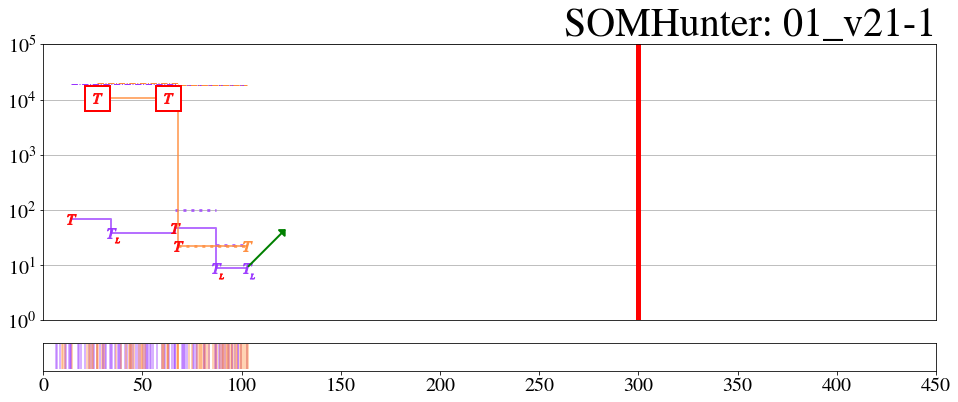

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 01_v21-1 ---

		###!!!### 52.72 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (556, 1154038, 19239) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 63.77 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (40, 1154038, 19083) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 119.94 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- [] -
		- (40, 1154038, 19083) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 01_v21-1 ---

		###!!!##

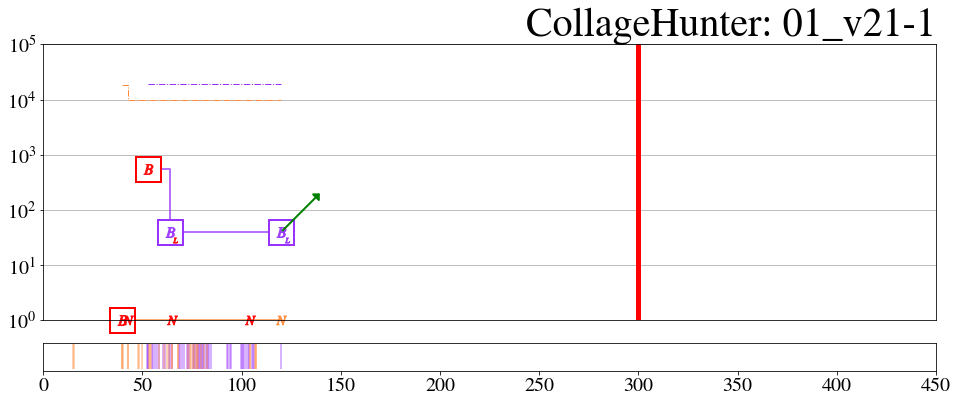

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 01_v21-1 ---

		###!!!### 23.58 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (355, 1154038, 18516) -
		- ['|results|road motorcycle;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 34.06 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (286, 1154038, 17949) -
		- ['|results|road motorcycle >> shadow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 57.65 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (70, 1154038, 19000) -
		- ['|results|road shadow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 83.68 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (99, 1154038, 17717) -
		- ['|results|road curb 

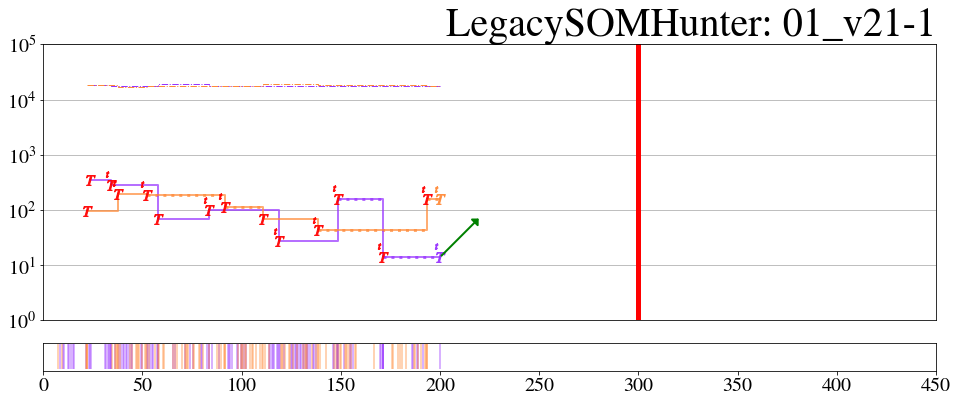

A

%%%%%%%%%%%%%%%
%%% 03_t21-1 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 03_t21-1 ---

		###!!!### 10.79 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (42, 1154038, 18488) -
		- ['|results|graffiti;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 20.38 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (43, 1154038, 18493) -
		- ['|results|graffiti;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 137.81 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (40, 1154038, 18503) -
		- ['|results|graffiti;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 243.90 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (26, 1154038, 18417) -
		- ['|results|graffiti p

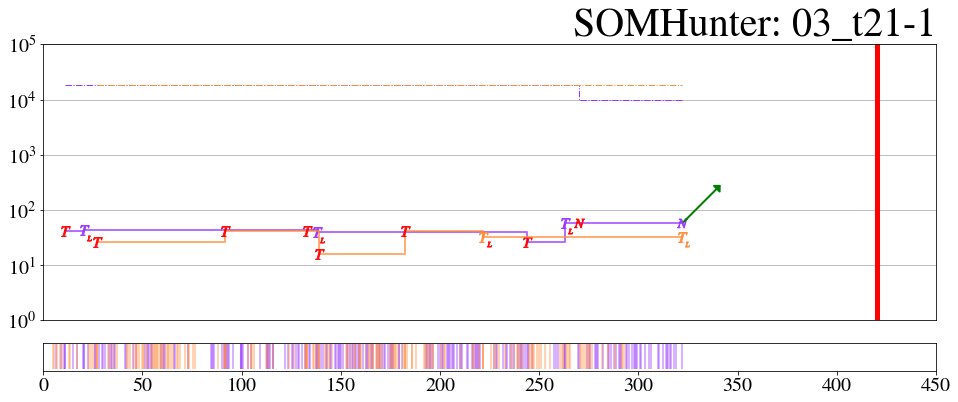

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 03_t21-1 ---

		###!!!### 35.60 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (25, 41, 18663) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 46.23 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (2, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 75.13 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (25, 41, 18663) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 147.78 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (1, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromSho

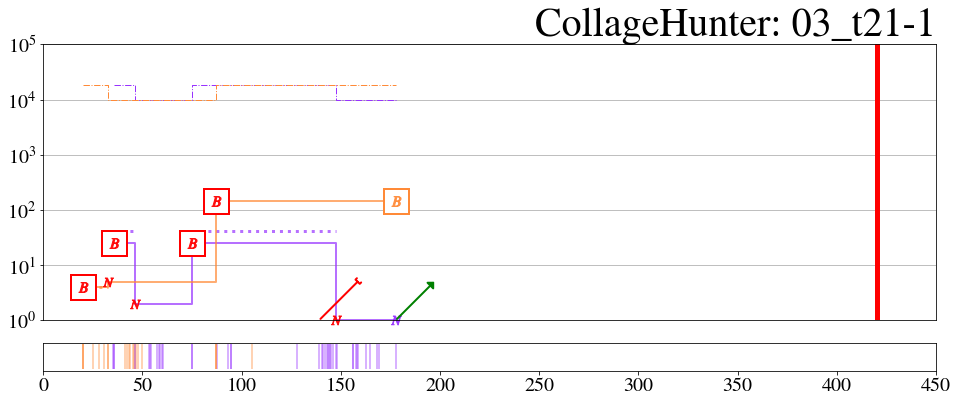

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 03_t21-1 ---

		###!!!### 0.01 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (4456, 1154038, 9443) -
		- ['|results|person flag holding;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 23.48 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (4415, 1154038, 18885) -
		- ['|results|graffity artist;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 41.60 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (60, 1154038, 18741) -
		- ['|results|graffity spraying;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 48.99 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (2971, 1154038, 17075) -
		- ['|results|graffity s

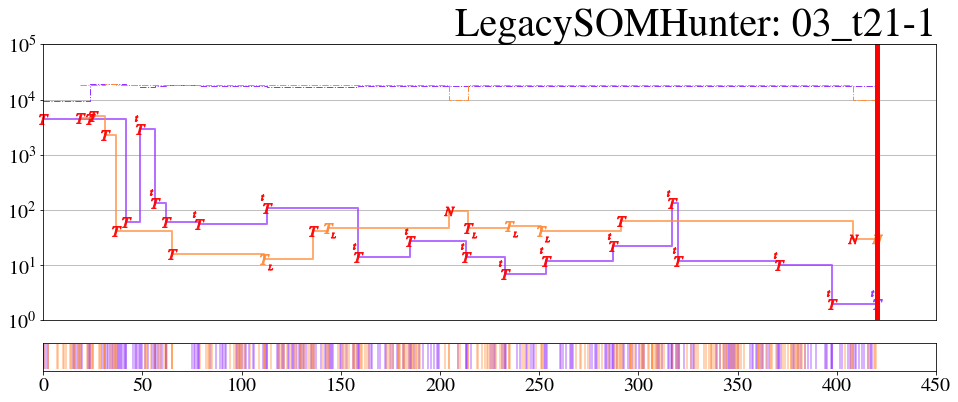


%%%%%%%%%%%%%%%
%%% 04_v21-2 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 04_v21-2 ---

		###!!!### 26.43 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (39, 1154038, 18470) -
		- ['|results|motorbike dirt road;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 42.02 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (284, 1154038, 18482) -
		- ['|results|dirt road;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 95.15 ###!!!###
		- REPORT RESULTS -
		- ['TQR'] -
		- ['TQR'] -
		- (331, 1154038, 18411) -
		- ['|results|dirt road;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 112.53 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (687, 1154038, 18439) -
		- ['|results|buggy d

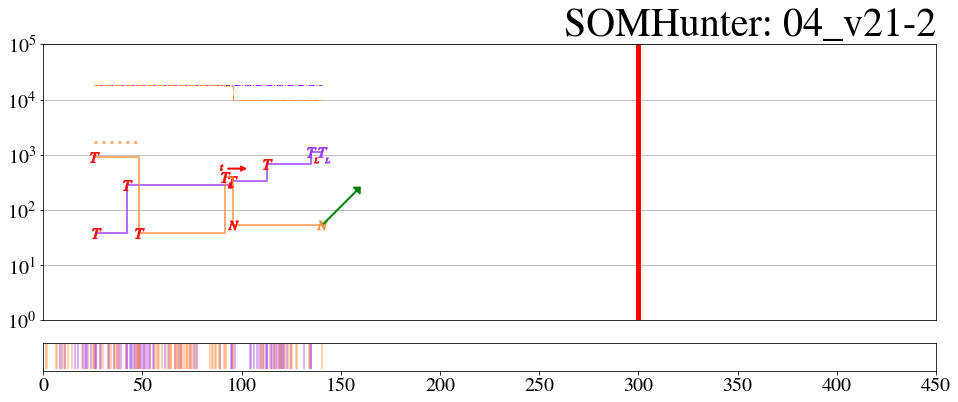

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 04_v21-2 ---

		###!!!### 47.01 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (5, 1154038, 18808) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 73.38 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (5, 1154038, 18808) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 04_v21-2 ---

		###!!!### 25.05 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (17, 1154038, 18762) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 51.24 ###!!!#

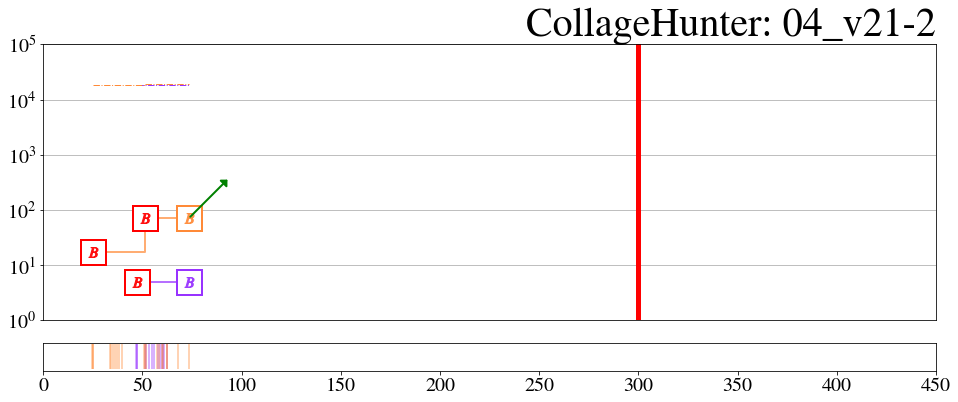

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 04_v21-2 ---

		###!!!### 77.83 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (1453, 1154038, 17348) -
		- ['|results|people driving >> trees;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 101.08 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (3961, 1154038, 17291) -
		- ['|results|people driving >> trees sky;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 108.51 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (395, 1154038, 17396) -
		- ['|results|people driving >> trees hill;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 114.80 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (969, 11540

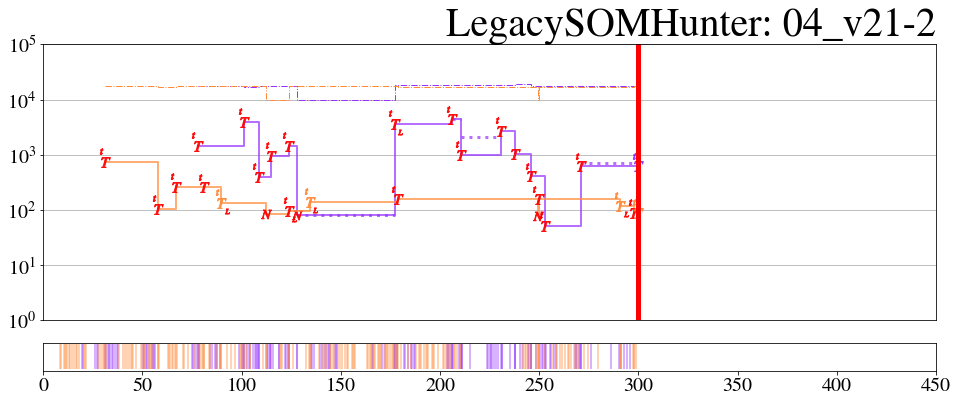

A

%%%%%%%%%%%%%%%
%%% 06_t21-2 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 06_t21-2 ---

		###!!!### 14.84 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (202, 202, 18386) -
		- ['|results|window hand;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 60.17 ###!!!###
		- REPORT RESULTS -
		- ['TQR', 'LK'] -
		- ['TQR', 'LK'] -
		- (1089, 1089, 18458) -
		- ['|results|window hand;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 76.99 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (227, 1154038, 18491) -
		- ['|results|window snow mountain;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 105.12 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (122, 122, 18503) -
		- ['

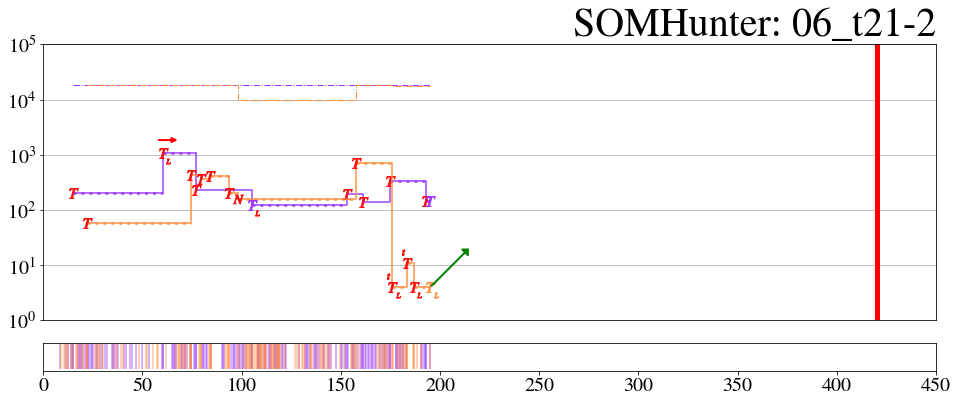

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 06_t21-2 ---

		###!!!### 41.27 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (7824, 7824, 18681) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 62.58 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (4327, 4327, 18591) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 76.67 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (3414, 3414, 18562) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 96.60 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (8405, 8405, 18680) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true

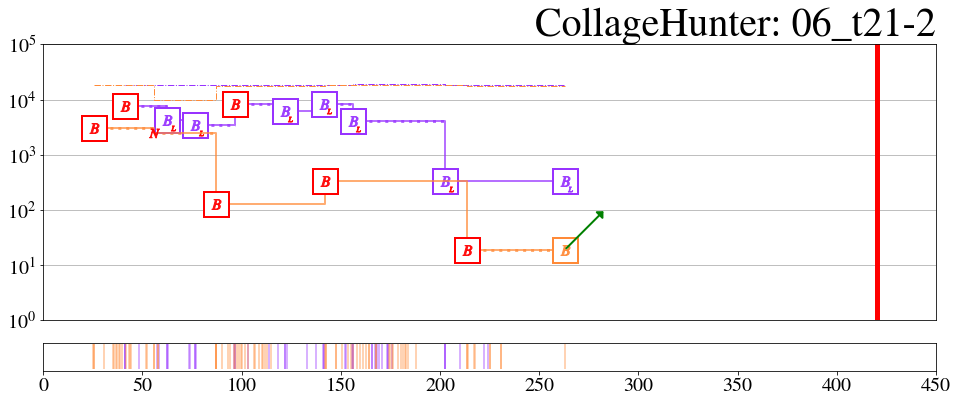

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 06_t21-2 ---

		###!!!### 23.33 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (5, 5, 17729) -
		- ['|results|hand window >> mountain;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 31.81 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (3, 3, 17672) -
		- ['|results|hand window >> mountain hut;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 43.99 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (5, 5, 17757) -
		- ['|results|hand window opening >> mountain hut;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 50.23 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (168, 168, 18431) -
		- ['|results|

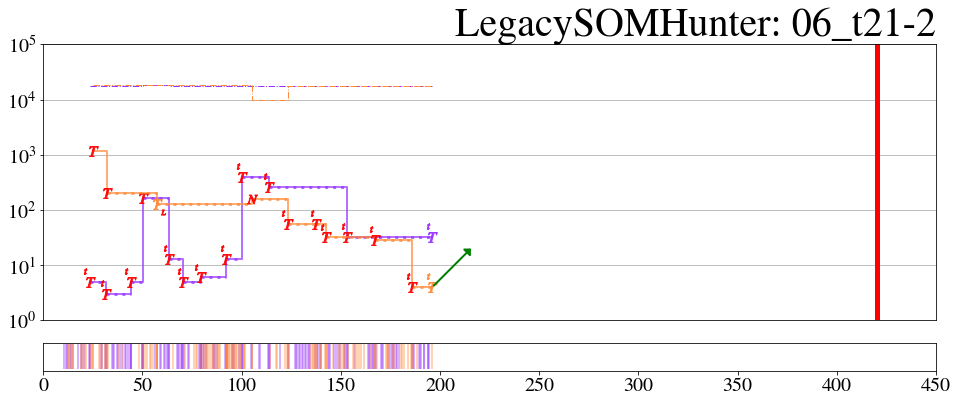


%%%%%%%%%%%%%%%
%%% 07_v21-3 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 07_v21-3 ---

		###!!!### 24.72 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (71, 82, 16949) -
		- ['|results|snow mountain >> snow mountain;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 65.59 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (16, 18, 17208) -
		- ['|results|snow mountain >> snow mountain;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 90.67 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- [] -
		- (16, 18, 17208) -
		- ['|results|snow mountain >> snow mountain;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***#########

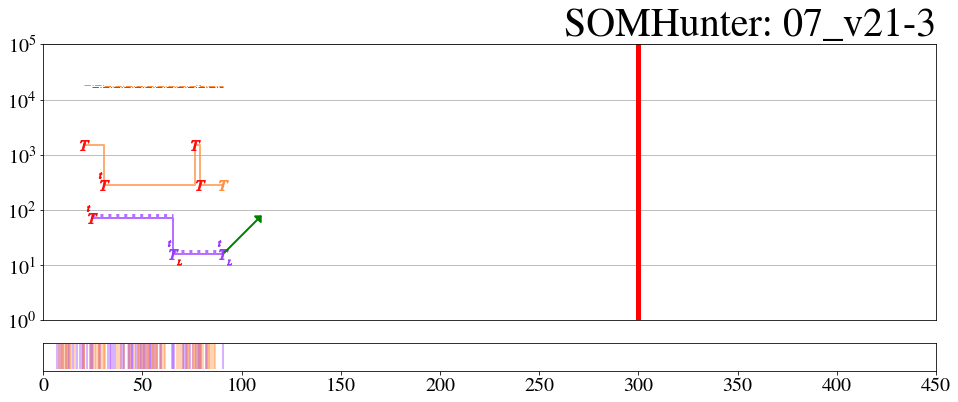

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 07_v21-3 ---

		###!!!### 45.57 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (46, 1154038, 18603) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 83.52 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (70, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 117.59 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (97, 117, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 140.65 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (39, 1154038, 10000) -
		- ['|results|;showNearestNeighb

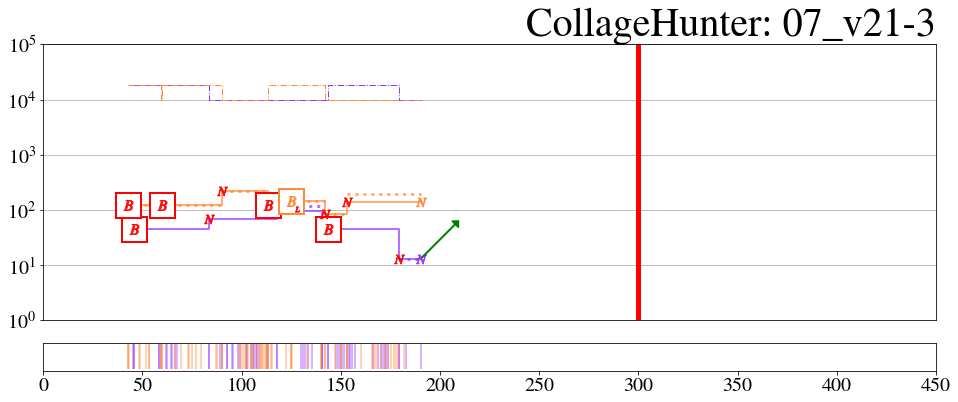

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 07_v21-3 ---

		###!!!### 17.44 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (277, 1154038, 18746) -
		- ['|results|mountain snowball;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 27.76 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (73, 1154038, 18573) -
		- ['|results|mountain snow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 34.32 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (304, 1154038, 17257) -
		- ['|results|mountain snow >> trees;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 113.79 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (358, 1154038, 17186) -
		- ['|results|mountai

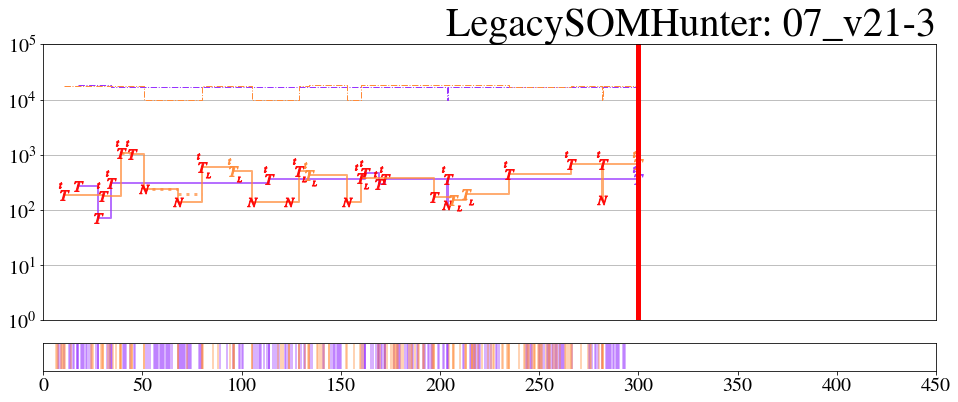


%%%%%%%%%%%%%%%
%%% 08_t21-7 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 08_t21-7 ---

		###!!!### 12.19 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (433, 1154038, 19297) -
		- ['|results|young eating;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 24.30 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (471, 1154038, 19285) -
		- ['|results|young eating;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 41.04 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (346, 1154038, 19306) -
		- ['|results|young eating;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 93.95 ###!!!###
		- REPORT RESULTS -
		- ['TQR'] -
		- ['TQR'] -
		- (353, 1154038, 18966) -
		- ['|resu

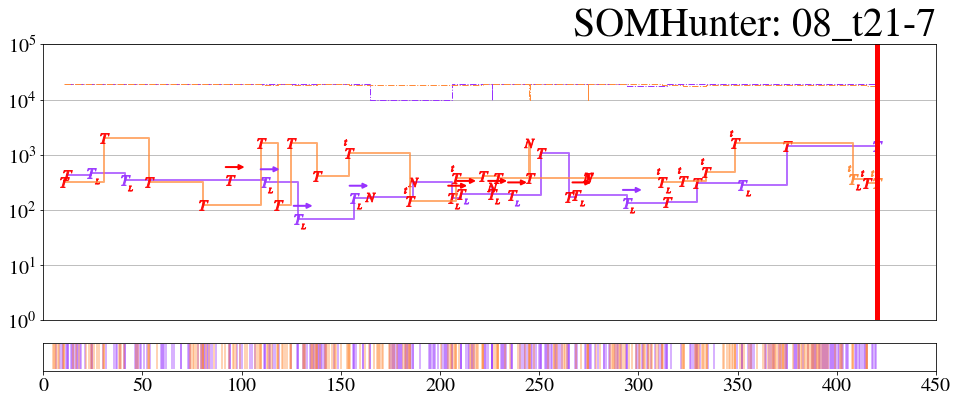

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 08_t21-7 ---

		###!!!### 35.26 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (2, 1154038, 18851) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 98.54 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (30, 30, 19075) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 116.35 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (10, 10, 19036) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 137.35 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (49, 227, 19088) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

	

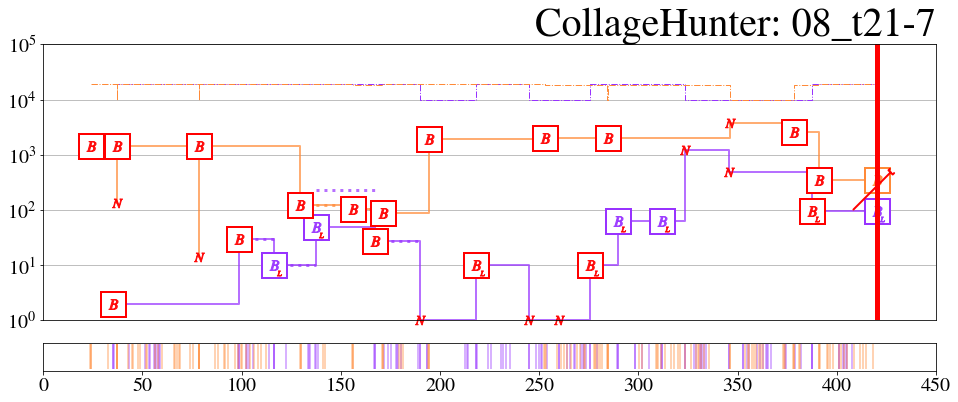

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 08_t21-7 ---

		###!!!### 14.79 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (27, 1154038, 19117) -
		- ['|results|man sitting eating;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 26.26 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (216, 1154038, 18535) -
		- ['|results|man sitting eating >> outside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 32.06 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (89, 1154038, 18479) -
		- ['|results|man sitting eating >> oudoors;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 35.84 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (89, 1154038, 18479) -

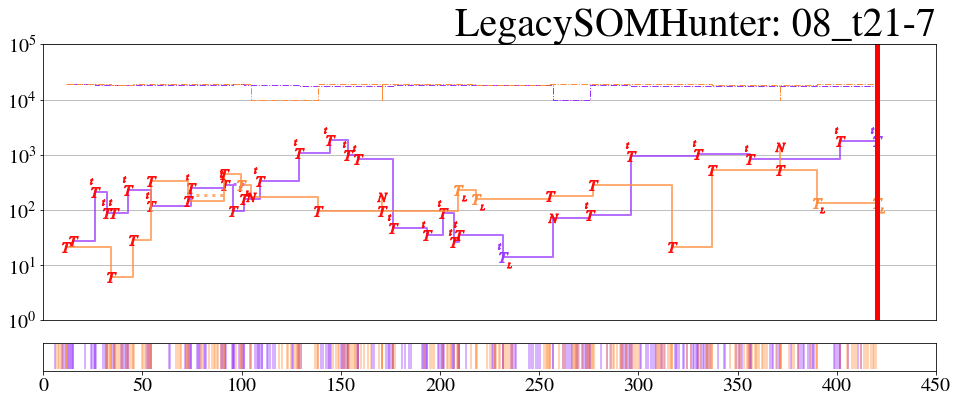

A
A

%%%%%%%%%%%%%%%
%%% 11_v21-4 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 11_v21-4 ---

		###!!!### 20.16 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (85, 1154038, 17150) -
		- ['|results|snowboard >> snowboard;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 27.94 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (116, 188, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 28.00 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (85, 1154038, 17150) -
		- ['|results|snowboard >> snowboard;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 49.63 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (72, 72, 1

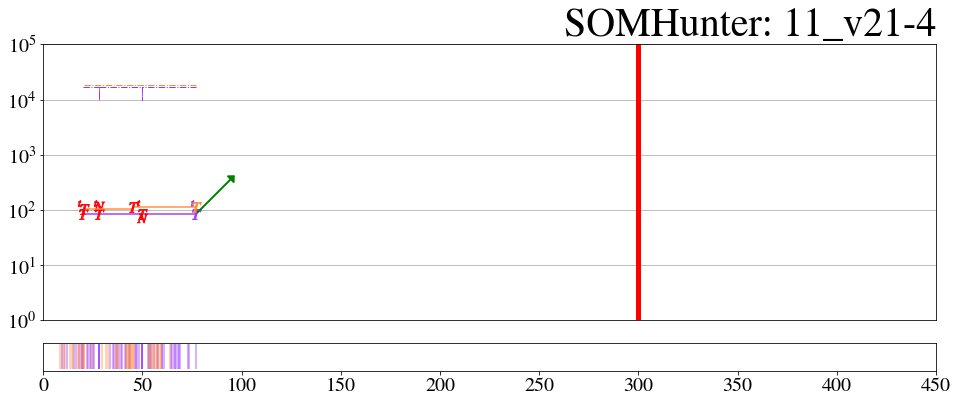

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 11_v21-4 ---

		###!!!### 62.02 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (49, 1154038, 18944) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 114.86 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (14, 14, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 158.60 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (14, 14, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 163.88 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (49, 1154038, 18944) -
		- ['|results|;fromVideoLimit=3;fro

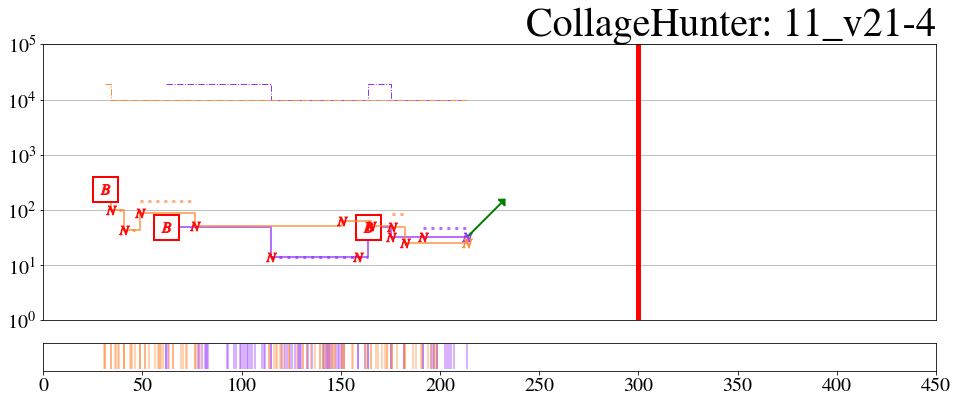

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 11_v21-4 ---

		###!!!### 18.65 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (146, 286, 18825) -
		- ['|results|snowboard snow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 29.10 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (112, 1154038, 18010) -
		- ['|results|snowboard snow >> green jacket;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 51.60 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (68, 1154038, 18110) -
		- ['|results|snowboard snow >> green jacket;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 63.79 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (12, 201, 10000) -
		- [

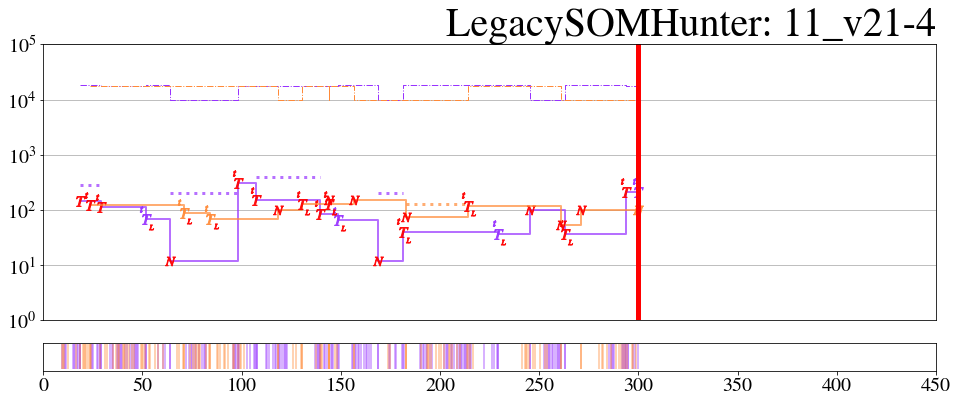


%%%%%%%%%%%%%%%
%%% 12_t21-3 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 12_t21-3 ---

		###!!!### 22.80 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (2, 1154038, 18865) -
		- ['|results|vintage hurdle race;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 175.20 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- [] -
		- (2, 1154038, 18865) -
		- ['|results|vintage hurdle race;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-vit ---
		--- 12_t21-3 ---

		###!!!### 19.48 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (1972, 1154038, 18823) -
		- ['|results|historic hurdle;fromVideoLimit=3;fromShotLimi

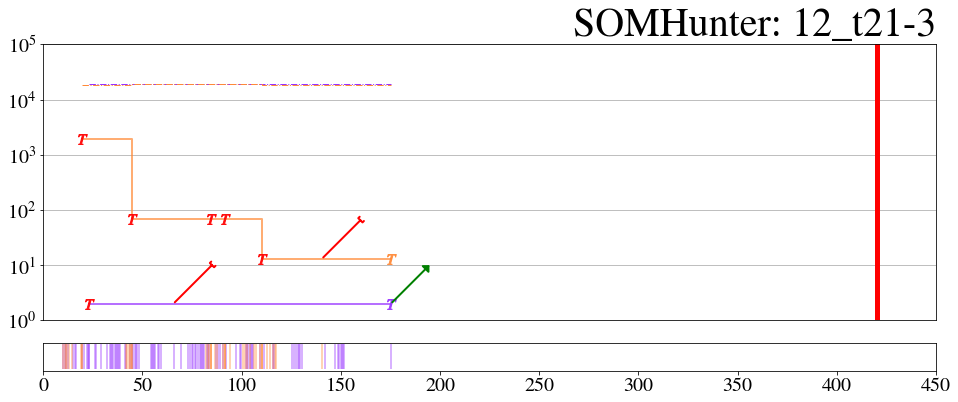

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 12_t21-3 ---

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 12_t21-3 ---

		###!!!### 26.99 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (9, 9, 19249) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 38.49 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (9, 9, 19249) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -



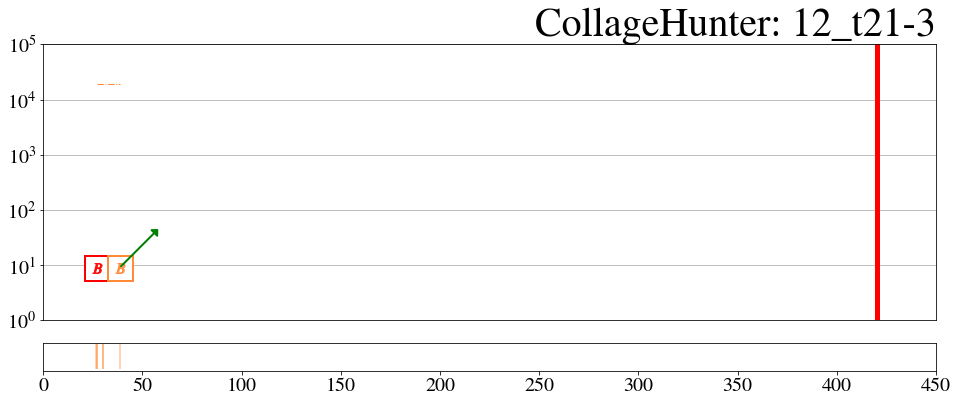

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 12_t21-3 ---

		###!!!### 29.75 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (1517, 1154038, 18917) -
		- ['|results|discus throwing;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 40.23 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (405, 1154038, 18964) -
		- ['|results|hurdle hurdle;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 45.50 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (3367, 1154038, 18179) -
		- ['|results|hurdle hurdle >> historic;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 60.71 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (2400, 1154038, 18063) -
		- ['|results|hur

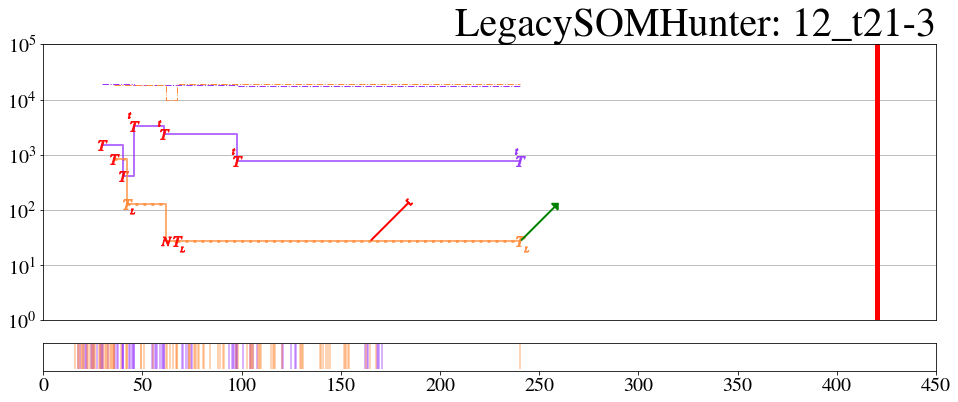

A

%%%%%%%%%%%%%%%
%%% 14_t21-4 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 14_t21-4 ---

		###!!!### 28.26 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (490, 490, 18311) -
		- ['|results|running man tree;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 37.38 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (1046, 1046, 18414) -
		- ['|results|running man tree;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 61.65 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (722, 722, 18444) -
		- ['|results|running man tree;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 78.76 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (12, 1154038, 19711) -
		- ['|res

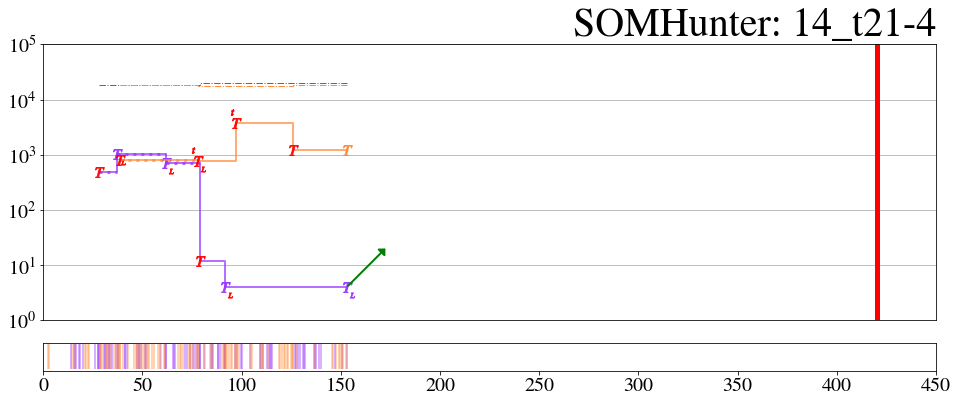

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 14_t21-4 ---

		###!!!### 61.98 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (44, 44, 18890) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 85.03 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (1, 1, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 127.99 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (2537, 2718, 18639) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 170.90 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (854, 1190, 18761) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFil

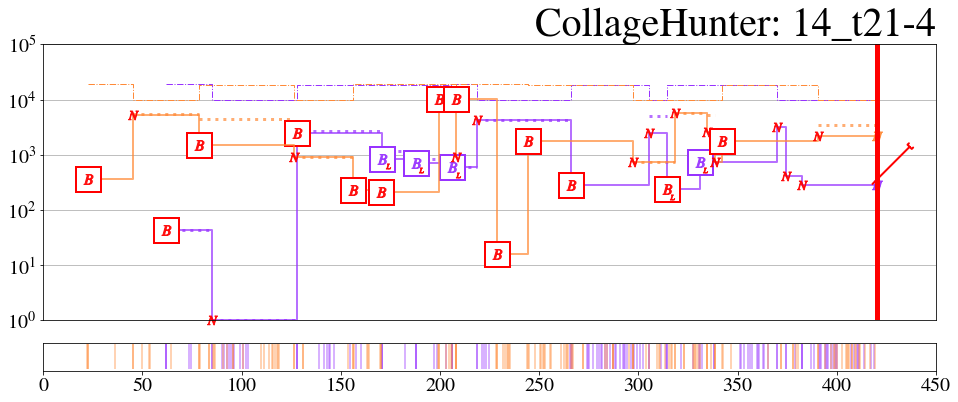

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 14_t21-4 ---

		###!!!### 29.72 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (1015, 1601, 18871) -
		- ['|results|black man street;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 67.63 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (541, 702, 18759) -
		- ['|results|black man street;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 73.96 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (268, 331, 18153) -
		- ['|results|black man street >> bench;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 81.37 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- [] -
		- (268, 331, 18153) -
		- ['|results|black man stree

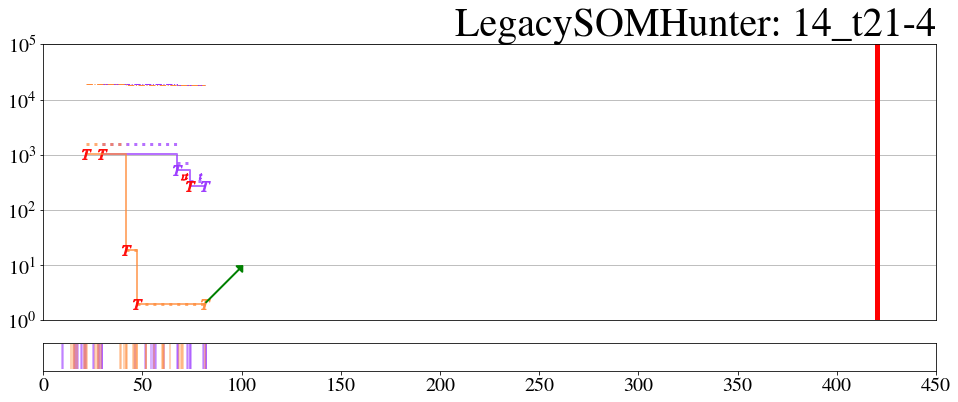


%%%%%%%%%%%%%%%
%%% 15_v21-5 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 15_v21-5 ---

		###!!!### 12.61 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (19, 19, 18985) -
		- ['|results|black bowl;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 19.47 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (161, 161, 18965) -
		- ['|results|black bowl;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 47.21 ###!!!###
		- REPORT RESULTS -
		- ['TQR'] -
		- ['TQR'] -
		- (93, 93, 18986) -
		- ['|results|black bowl;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 88.98 ###!!!###
		- REPORT RESULTS -
		- ['TQR'] -
		- [] -
		- (93, 93, 18986) -
		- ['|results|black bowl;fromVideoLimit=3;fromS

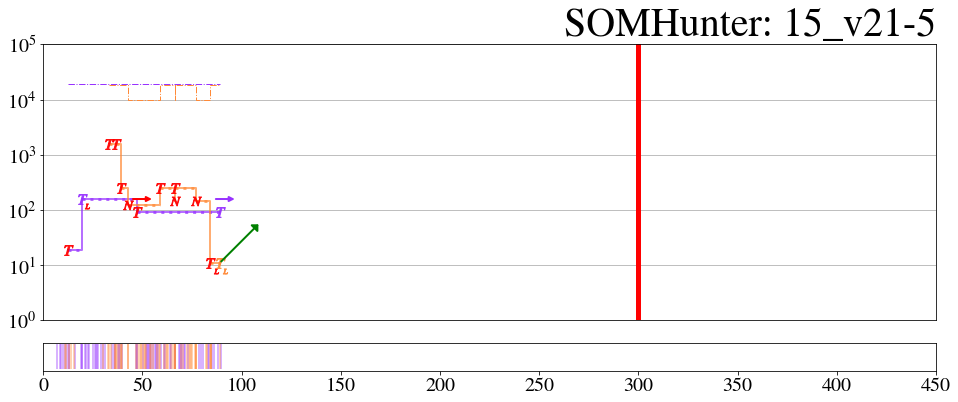

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 15_v21-5 ---

		###!!!### 30.20 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (554, 554, 19235) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 43.76 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (188, 188, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 56.32 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (188, 188, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 74.56 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (554, 554, 19235) -
		- ['|results|;fromVideoLimit=3;fromShot

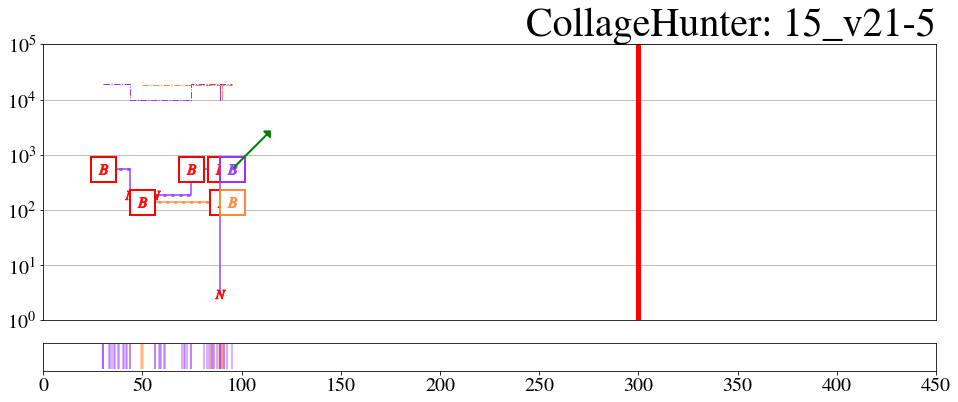

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 15_v21-5 ---

		###!!!### 20.83 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (9, 9, 18779) -
		- ['|results|pot pouring water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 23.95 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- [] -
		- (9, 9, 18779) -
		- ['|results|pot pouring water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-franta-tomas ---
		--- 15_v21-5 ---

		###!!!### 13.73 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (6, 6, 17254) -
		- ['|results|pot >> smoke pot;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilte

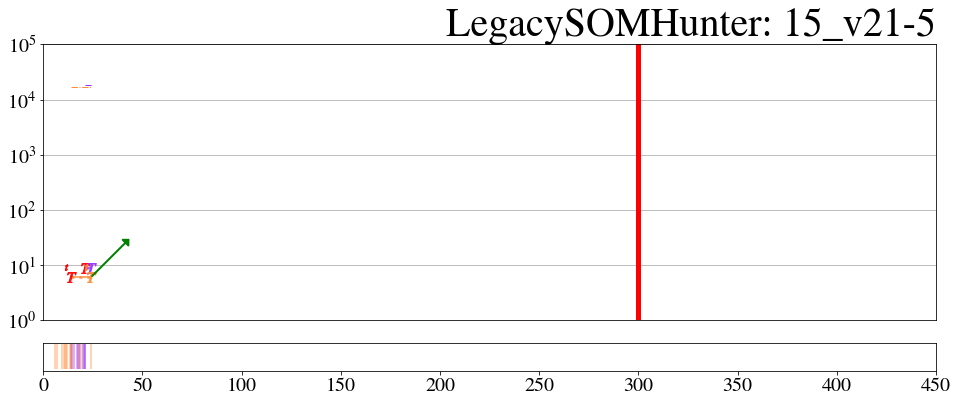


%%%%%%%%%%%%%%%
%%% 16_t21-5 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 16_t21-5 ---

		###!!!### 16.00 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (1537, 1537, 17464) -
		- ['|results|black car >> man car;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 59.84 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (1053, 1053, 17874) -
		- ['|results|black car >> man car;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 142.85 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (121, 676, 18000) -
		- ['|results|black car >> cap face;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 218.21 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (313, 763, 1

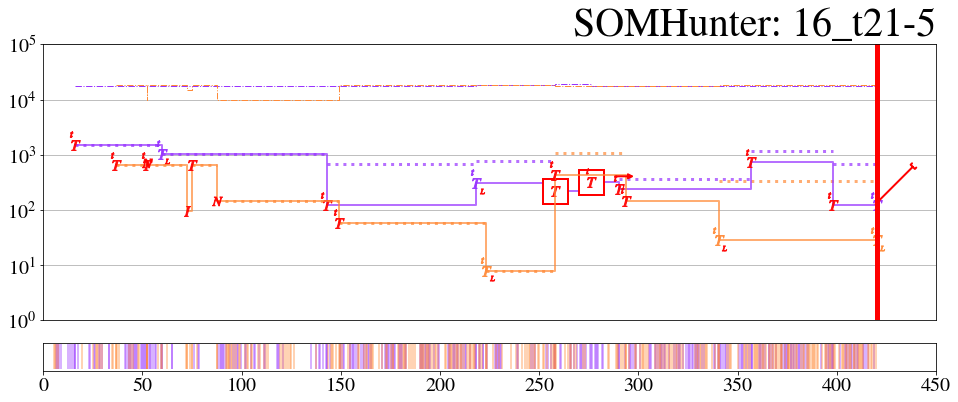

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 16_t21-5 ---

		###!!!### 62.53 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (1875, 1154038, 18672) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 118.39 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (19, 2661, 18975) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 166.04 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (282, 282, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 166.12 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (19, 2661, 18975) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPart

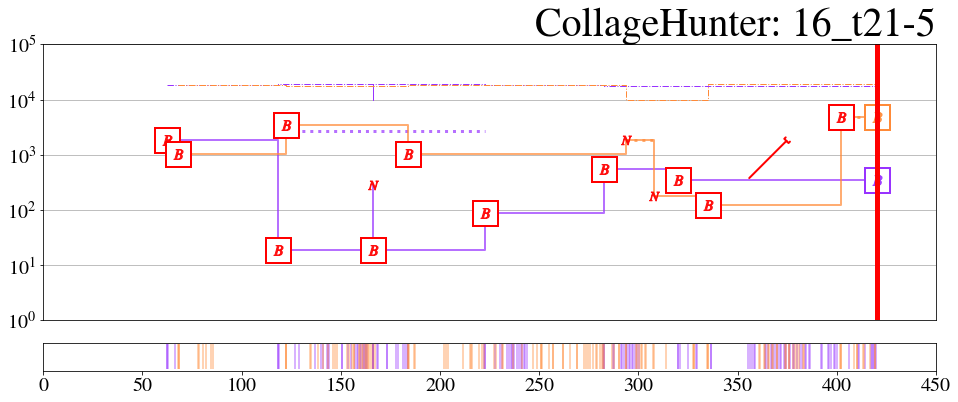

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 16_t21-5 ---

		###!!!### 29.97 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (644, 644, 18457) -
		- ['|results|black car >> man;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 43.66 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (863, 863, 18212) -
		- ['|results|black car >> man driving;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 85.45 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (233, 603, 18233) -
		- ['|results|black car wheel >> man driving;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 140.52 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (261, 261, 18099) -
		- ['|results|

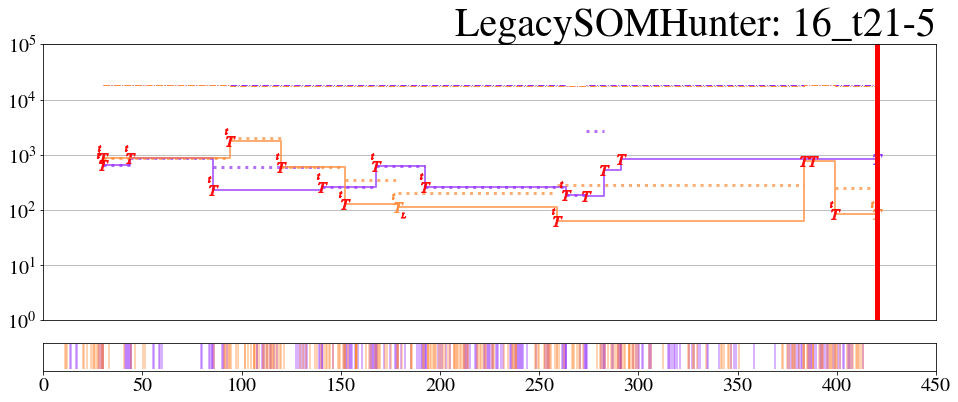


%%%%%%%%%%%%%%%
%%% 17_v21-6 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 17_v21-6 ---

		###!!!### 16.76 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (113, 1154038, 17567) -
		- ['|results|wedding >> bride;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 24.09 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (59, 1154038, 17810) -
		- ['|results|wedding >> bride indian;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 30.24 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (34, 1154038, 17589) -
		- ['|results|wedding indian >> bride indian;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 90.46 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (38, 11540

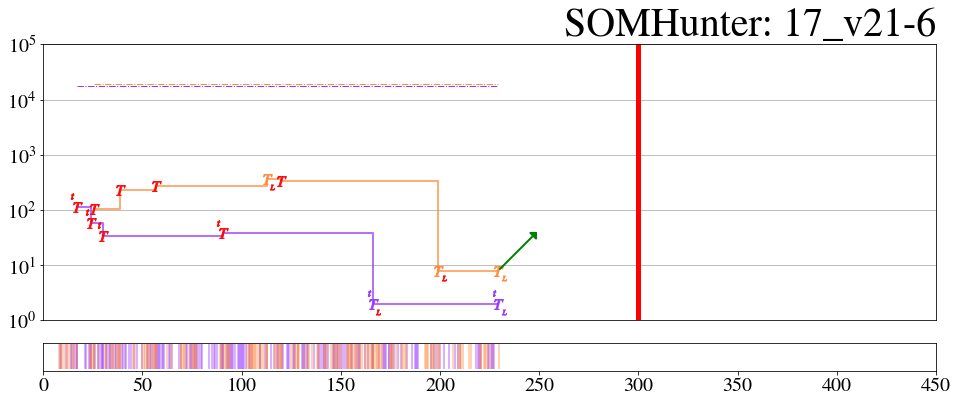

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 17_v21-6 ---

		###!!!### 27.88 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (9, 1154038, 18754) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 90.54 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (9, 1154038, 18754) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 17_v21-6 ---

		###!!!### 22.71 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (62, 64, 18991) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 57.66 ###!!!###
		

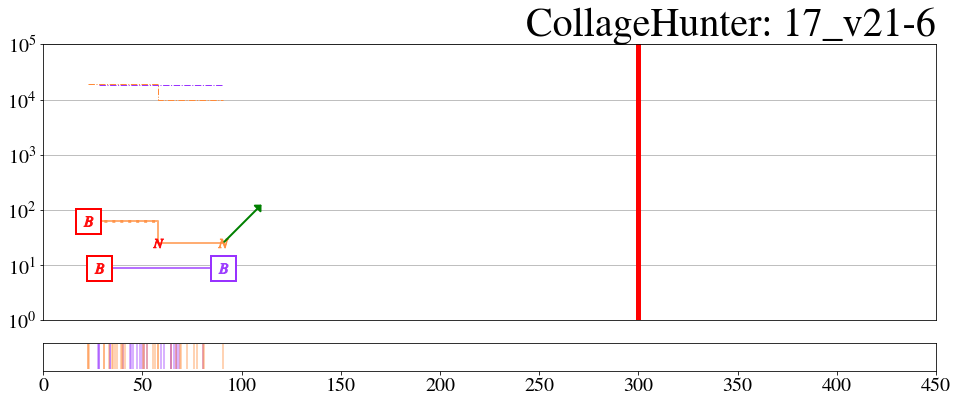

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 17_v21-6 ---

		###!!!### 13.14 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (74, 1154038, 19174) -
		- ['|results|wedding indian;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 37.59 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (98, 318, 18075) -
		- ['|results|wedding indian >> crowd;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 84.41 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (163, 555, 18045) -
		- ['|results|wedding indian india >> crowd;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 124.06 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (75, 1154038, 17843) -
		- ['|results|w

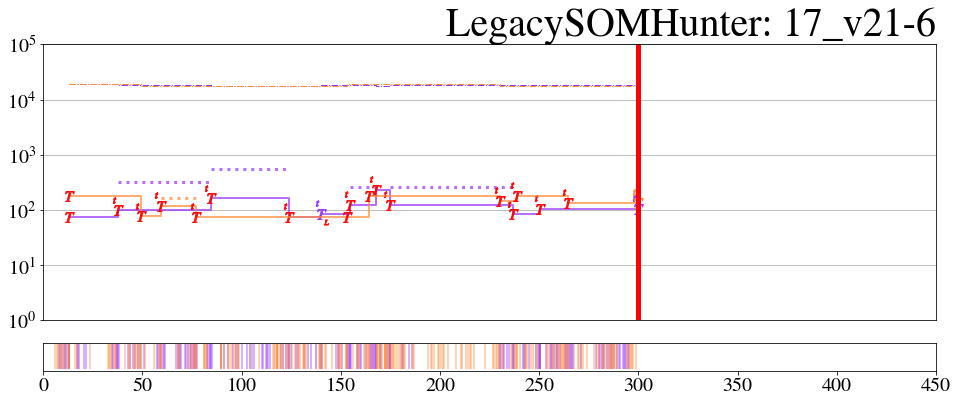


%%%%%%%%%%%%%%%
%%% 18_v21-7 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 18_v21-7 ---

		###!!!### 15.79 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (35, 1154038, 17885) -
		- ['|results|fish girl >> water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 58.87 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (32, 1154038, 17922) -
		- ['|results|fish girl >> water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 85.14 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (21, 1154038, 17958) -
		- ['|results|fish girl >> water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 99.84 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (28, 115403

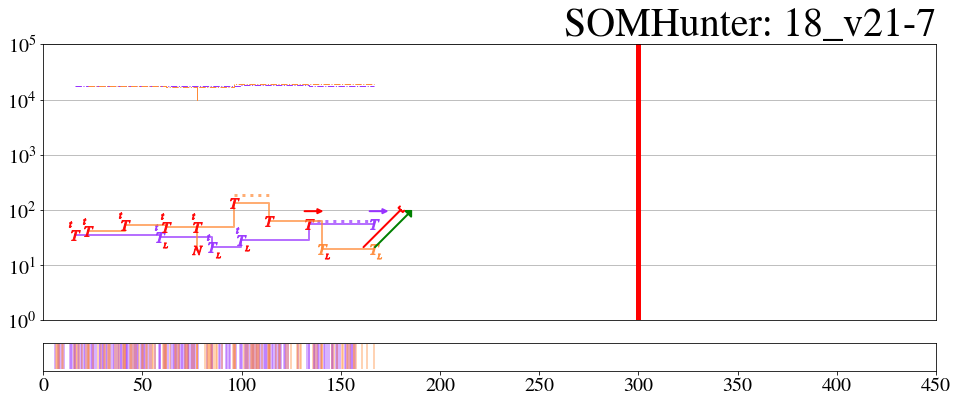

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 18_v21-7 ---

		###!!!### 35.66 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (6, 13, 18797) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 44.07 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (6, 13, 18797) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 18_v21-7 ---

		###!!!### 26.36 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (6, 15, 19044) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 35.84 ###!!!###
		- REPORT RE

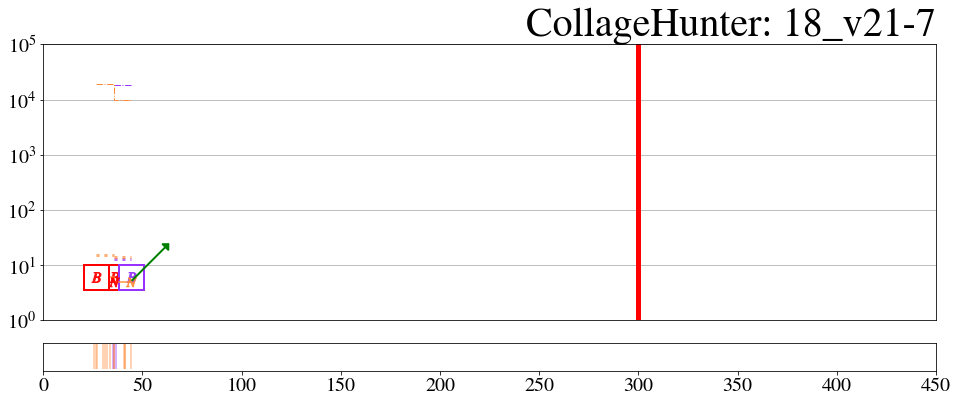

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 18_v21-7 ---

		###!!!### 21.12 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (41, 1154038, 19196) -
		- ['|results|woman fish;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 38.18 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (54, 87, 19089) -
		- ['|results|woman fish pink tshirt;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 55.59 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (41, 1154038, 19196) -
		- ['|results|woman fish;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 64.88 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (48, 1154038, 18824) -
		- ['|results|woman fish river;fromVideoLimi

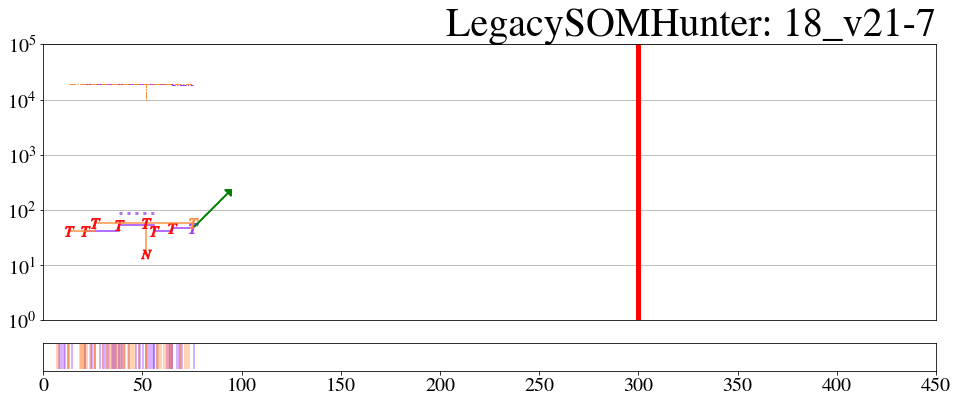

A

%%%%%%%%%%%%%%%
%%% 20_v21-8 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 20_v21-8 ---

		###!!!### 13.99 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (8, 8, 18787) -
		- ['|results|man beard talking;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 20.50 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (4, 4, 18872) -
		- ['|results|man beard talking;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 62.19 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- [] -
		- (4, 4, 18872) -
		- ['|results|man beard talking;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- s

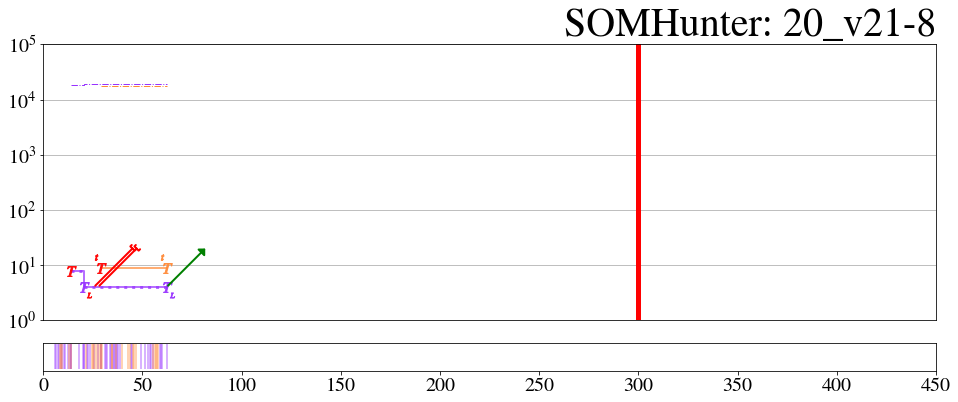

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 20_v21-8 ---

		###!!!### 66.50 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['CBQ', 'LK'] -
		- (252, 1154038, 18150) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 137.83 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (4, 1154038, 18871) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 152.32 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (761, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 152.41 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (4, 1154038, 18871) -
		- ['|results|;fromVideoLimit=3;fromShot

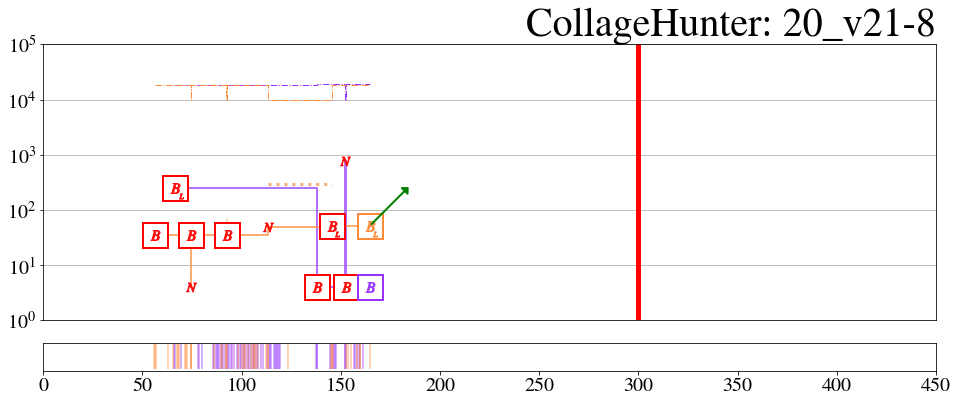

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 20_v21-8 ---

		###!!!### 18.08 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (109, 1154038, 18860) -
		- ['|results|man stalking;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 31.82 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (151, 580, 19643) -
		- ['|results|bench mana;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 43.55 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (36, 261, 19366) -
		- ['|results|bench man;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 49.74 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- [] -
		- (36, 261, 19366) -
		- ['|results|bench man;fromVideoLimit=3;fromShotLimit=1;dataset

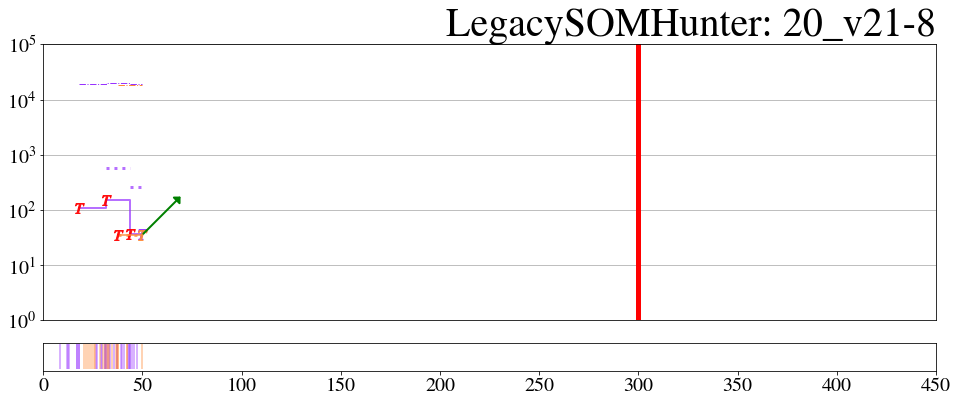


%%%%%%%%%%%%%%%
%%% 21_v21-9 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 21_v21-9 ---

		###!!!### 18.34 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (12, 12, 18631) -
		- ['|results|bug water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 30.63 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- [] -
		- (12, 12, 18631) -
		- ['|results|bug water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-vit ---
		--- 21_v21-9 ---

		###!!!### 28.96 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (1, 3, 18414) -
		- ['|results|fly bug water leaf;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'

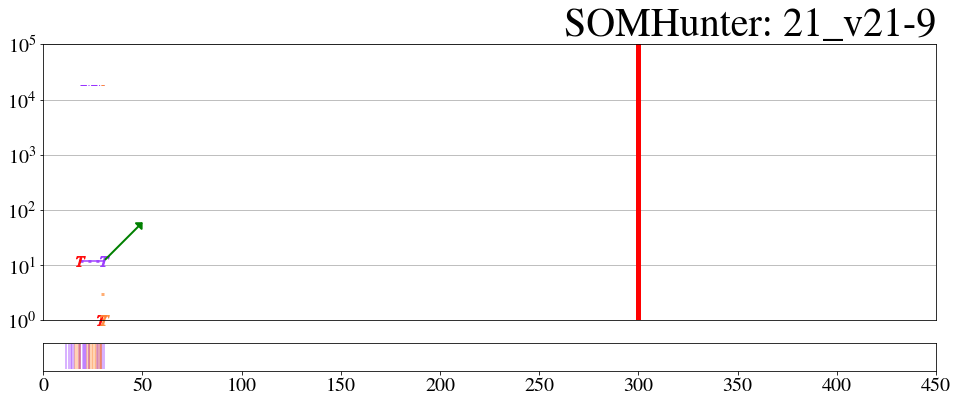

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 21_v21-9 ---

		###!!!### 31.91 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (7, 1154038, 18642) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 57.96 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (5, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 69.64 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (6, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 72.95 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (7, 1154038, 18642) -
		- ['|results|;fromVideoLimit=3;

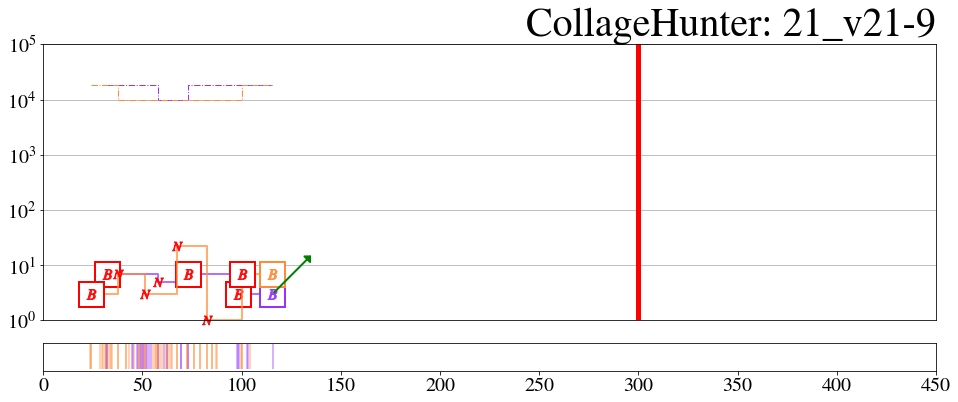

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 21_v21-9 ---

		###!!!### 34.65 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (740, 1154038, 18867) -
		- ['|results|dragonfly;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 53.21 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (276, 487, 18586) -
		- ['|results|dragonfly water lily;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 68.16 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (347, 1154038, 18552) -
		- ['|results|dragonfly water flower;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 96.16 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (347, 1154038, 18552) -
		- ['|results|dragonfly dragon

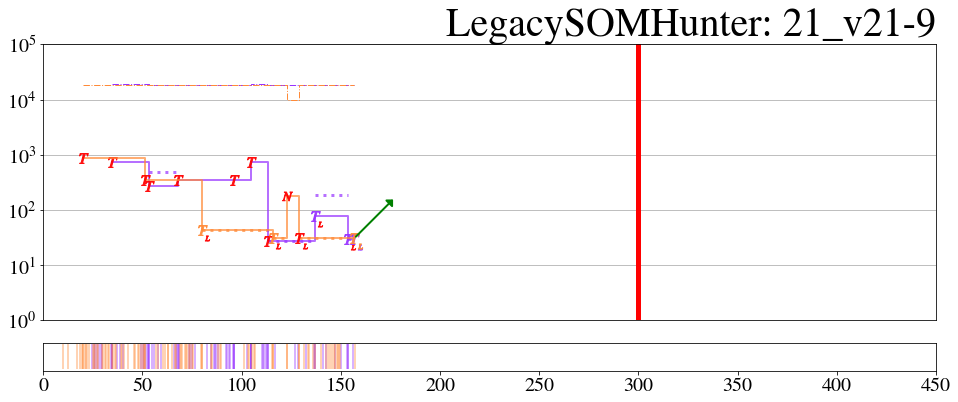


%%%%%%%%%%%%%%%
%%% 22_v21-10 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 22_v21-10 ---

		###!!!### 23.37 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (8098, 1154038, 18533) -
		- ['|results|dark >> presentation;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 30.16 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (2867, 1154038, 18734) -
		- ['|results|dark man standing >> presentation;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 42.66 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (1855, 1154038, 18772) -
		- ['|results|dark man standing >> presentation;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 53.94 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'T

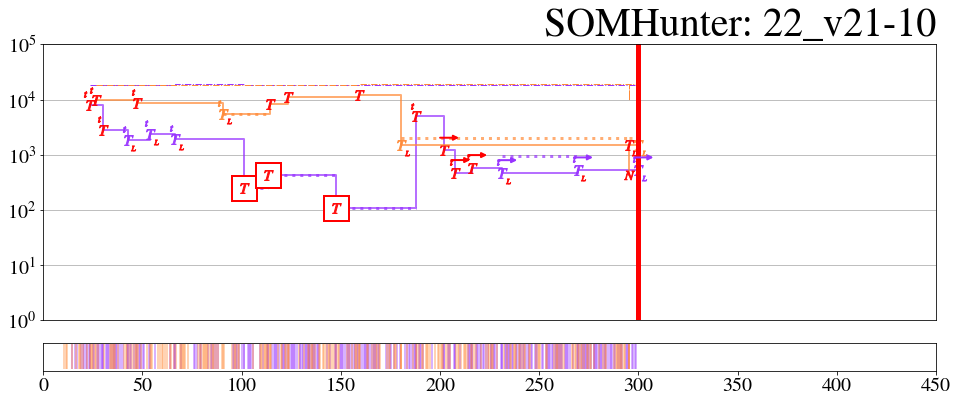

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 22_v21-10 ---

		###!!!### 61.65 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (930, 1885, 19061) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 96.05 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (585, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 111.36 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['CBQ', 'LK'] -
		- (363, 1283, 19010) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 125.78 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (95, 484, 19179) -
		- ['|results|;fromVideoLimit=3;fromShotLi

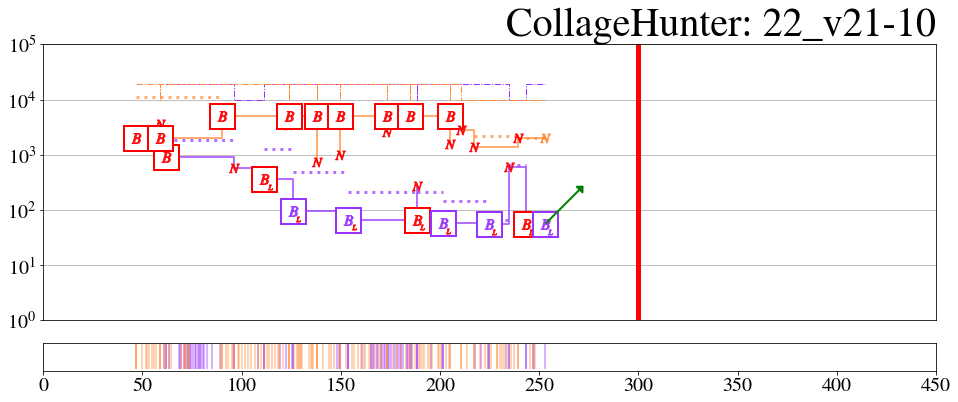

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 22_v21-10 ---

		###!!!### 24.19 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (2737, 1154038, 19210) -
		- ['|results|woman banner text;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 41.43 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (1918, 1154038, 18853) -
		- ['|results|woman banner banner bannertext;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 63.44 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (1256, 1154038, 18848) -
		- ['|results|woman banner banner banner;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 113.95 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (583, 1154038, 18757) -


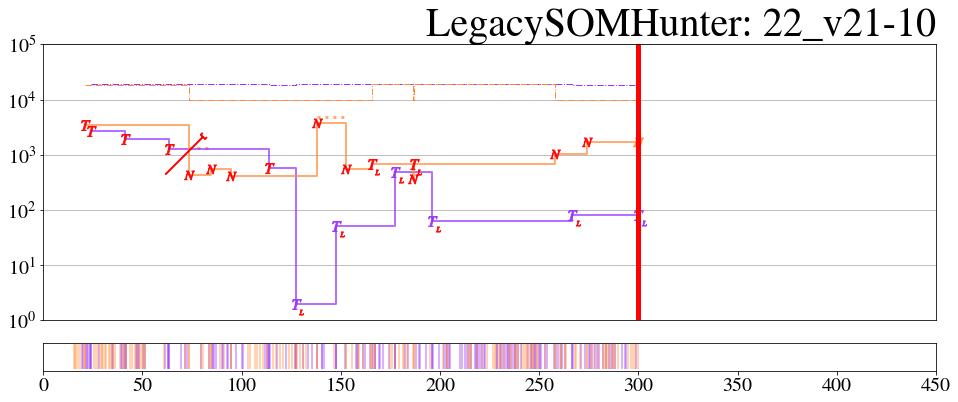


%%%%%%%%%%%%%%%
%%% 23_v21-11 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 23_v21-11 ---

		###!!!### 15.12 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (34, 34, 17112) -
		- ['|results|night city >> night city;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 21.18 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (53, 53, 17071) -
		- ['|results|night city >> night city;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 64.94 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (1, 1, 17704) -
		- ['|results|night city >> dusk;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 67.99 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- [] -
		- (1, 1, 17704) -
		- ['|result

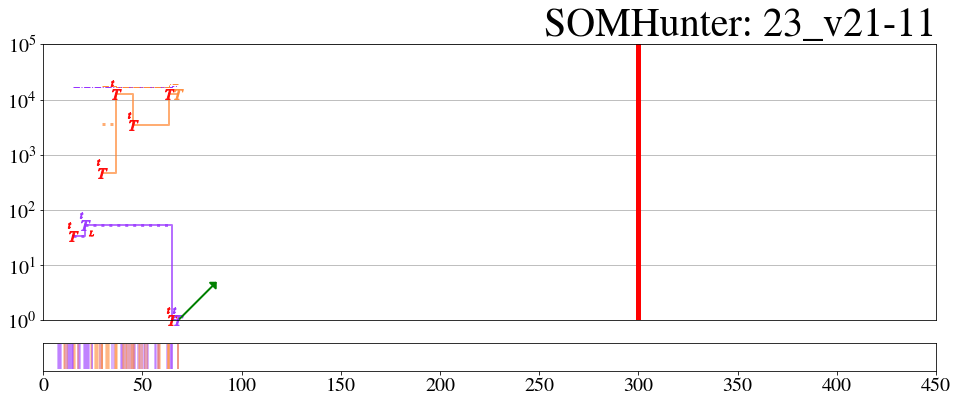

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 23_v21-11 ---

		###!!!### 39.12 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['CBQ', 'LK'] -
		- (808, 808, 18647) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 44.93 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- [] -
		- (808, 808, 18647) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 23_v21-11 ---

		###!!!### 30.53 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (17, 23, 18457) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 44

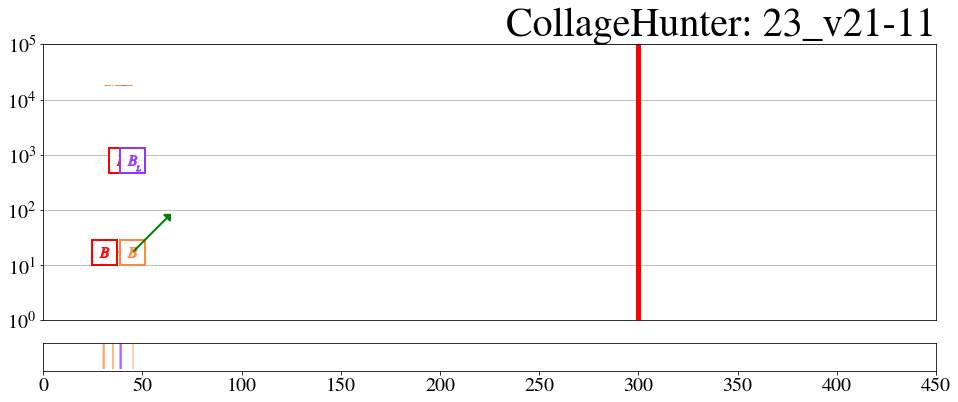

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 23_v21-11 ---

		###!!!### 14.38 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (7, 7, 18490) -
		- ['|results|city lights;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 38.44 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- [] -
		- (7, 7, 18490) -
		- ['|results|city lights;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-franta-tomas ---
		--- 23_v21-11 ---

		###!!!### 17.56 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (915, 915, 18345) -
		- ['|results|cityscape;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;']

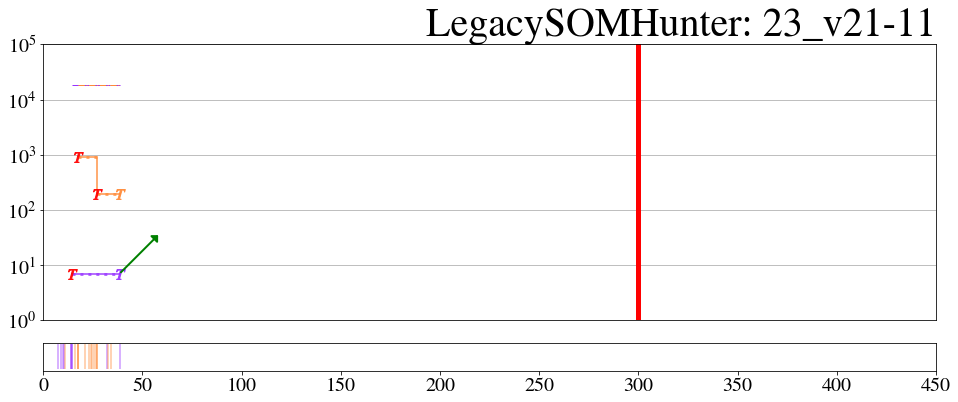


%%%%%%%%%%%%%%%
%%% 24_v21-12 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 24_v21-12 ---

		###!!!### 16.84 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (19, 1154038, 17810) -
		- ['|results|girl >> flag flag;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 23.16 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (6, 1154038, 17674) -
		- ['|results|girl >> flag flag;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 46.79 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- [] -
		- (6, 1154038, 17674) -
		- ['|results|girl >> flag flag;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
-

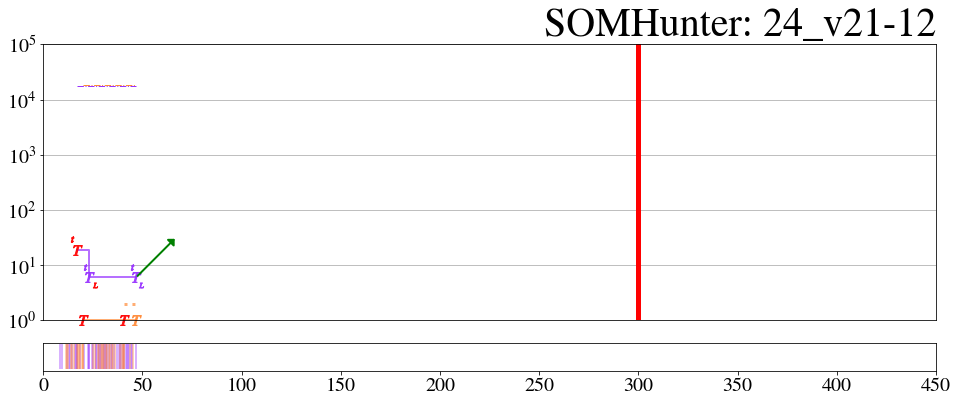

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 24_v21-12 ---

		###!!!### 140.95 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (1, 1, 18500) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 146.92 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (1, 1, 18500) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 24_v21-12 ---

		###!!!### 29.68 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (7, 1154038, 19008) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 131.99 ###!!!###
		- R

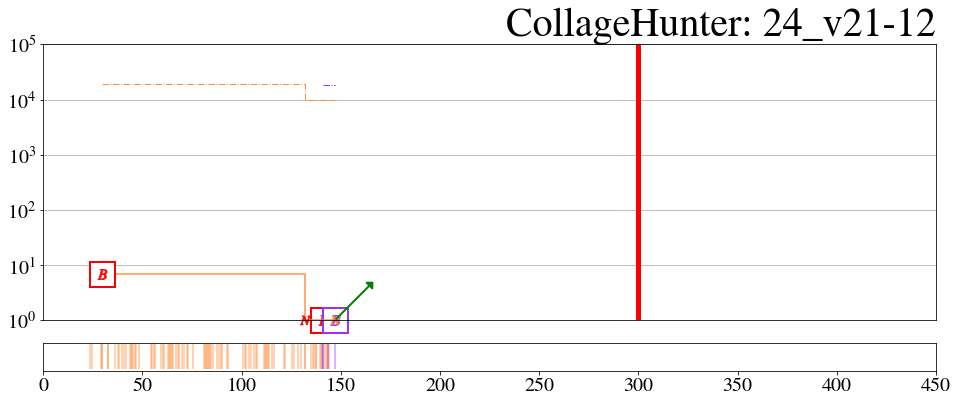

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 24_v21-12 ---

		###!!!### 19.68 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (26, 1154038, 18592) -
		- ['|results|flag stripes;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 26.90 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (1, 1154038, 18426) -
		- ['|results|flag stripes yellow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 48.09 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- [] -
		- (1, 1154038, 18426) -
		- ['|results|flag stripes yellow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-

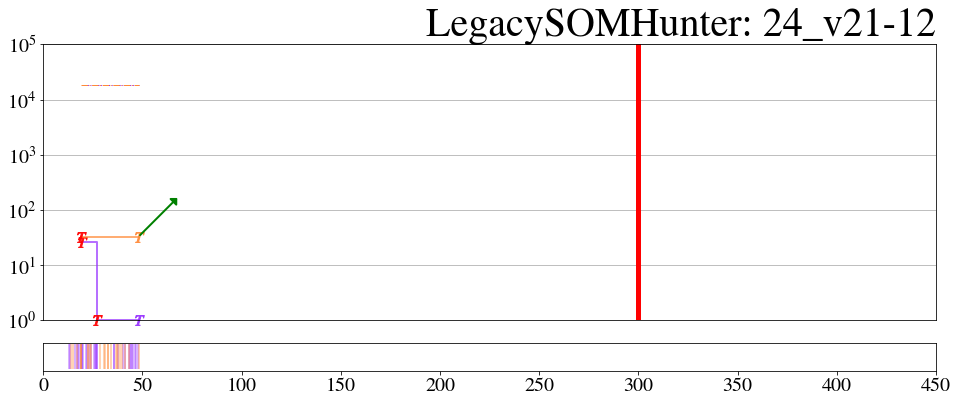


%%%%%%%%%%%%%%%
%%% 25_v21-13 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 25_v21-13 ---

		###!!!### 21.10 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (22, 22, 19027) -
		- ['|results|naked man;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 28.36 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (10, 10, 18941) -
		- ['|results|naked man;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 69.36 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (512, 512, 17931) -
		- ['|results|man dressing shirt >> woman face;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 75.63 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (393, 393, 18193) -
		- ['|results

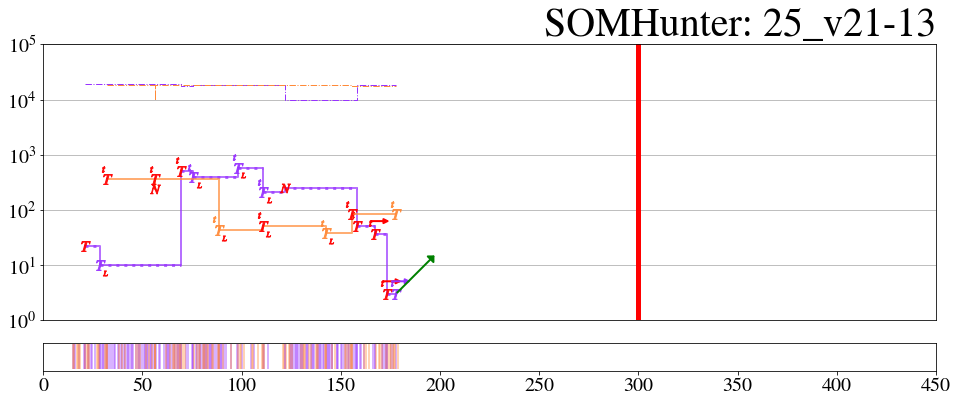

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 25_v21-13 ---

		###!!!### 47.51 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (1552, 1154038, 19023) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 71.16 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (4238, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 71.23 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (1552, 1154038, 19023) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 96.85 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (2802, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;from

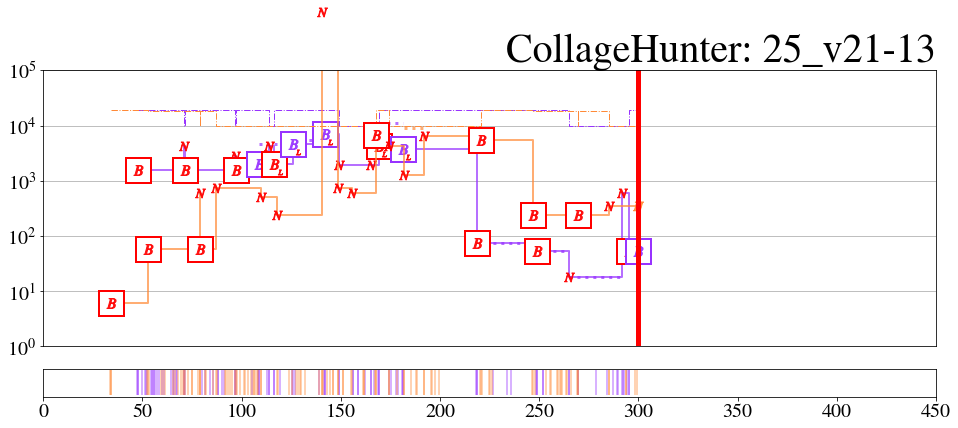

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 25_v21-13 ---

		###!!!### 45.70 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (131, 131, 18622) -
		- ['|results|man white shirt;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 73.71 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (82, 82, 17978) -
		- ['|results|man white shirt >> dressing;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 101.42 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (16, 16, 18228) -
		- ['|results|man naked >> dressing;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 153.38 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (26, 26, 18491) -
		- ['|results|man nake

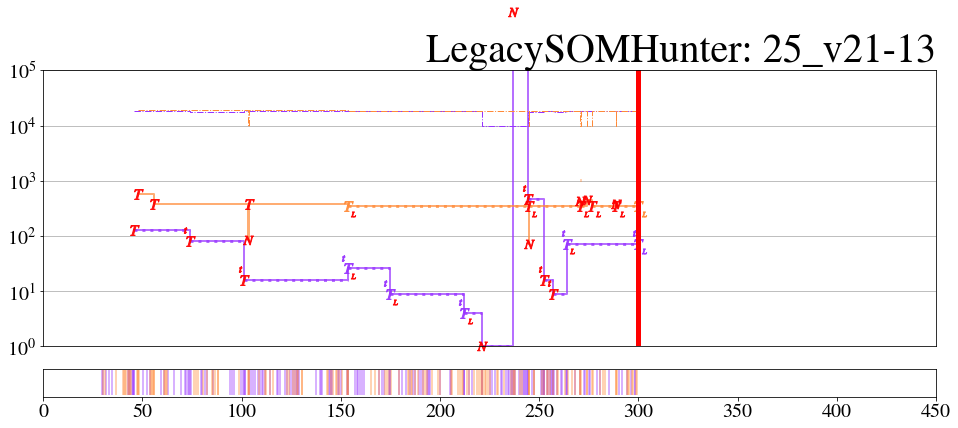

A

%%%%%%%%%%%%%%%
%%% 27_v21-14 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 27_v21-14 ---

		###!!!### 23.98 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (343, 1154038, 17858) -
		- ['|results|skateboard >> train inside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 34.08 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (336, 1154038, 17907) -
		- ['|results|skateboard skateboard >> train inside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 49.71 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (869, 1154038, 17657) -
		- ['|results|skateboard graffiti >> train inside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 57.12 ###!!!###
		- REPORT RESULTS -
		- ['T

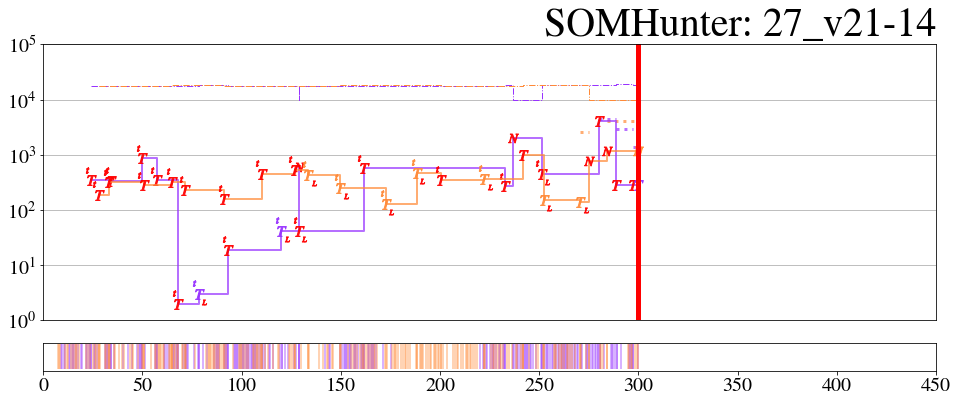

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 27_v21-14 ---

		###!!!### 41.22 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (9, 9, 18700) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 53.09 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (9, 9, 18700) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 27_v21-14 ---

		###!!!### 26.37 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (2963, 2963, 18924) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 32.73 ###!!!###
		- REPO

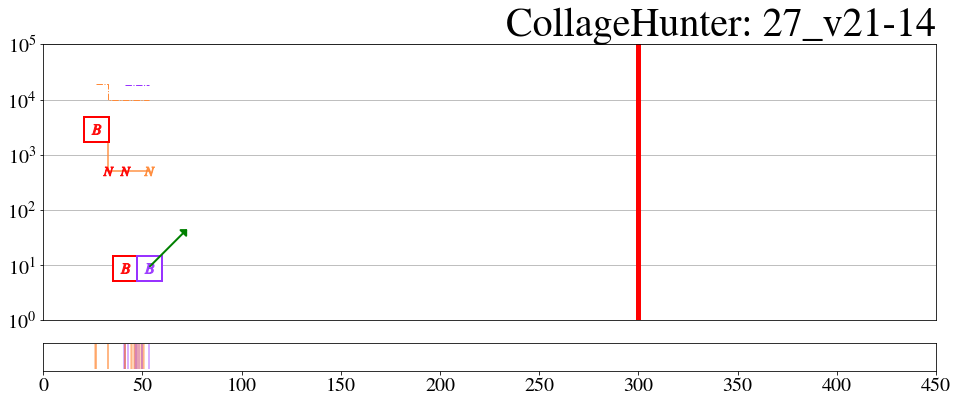

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 27_v21-14 ---

		###!!!### 14.37 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (867, 1154038, 18482) -
		- ['|results|subway;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 28.12 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (1659, 1154038, 19194) -
		- ['|results|black man phoning;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 38.00 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (190, 190, 18443) -
		- ['|results|black man phoning >> vest;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 83.49 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (47, 47, 18129) -
		- ['|results|red waistcoat >> ve

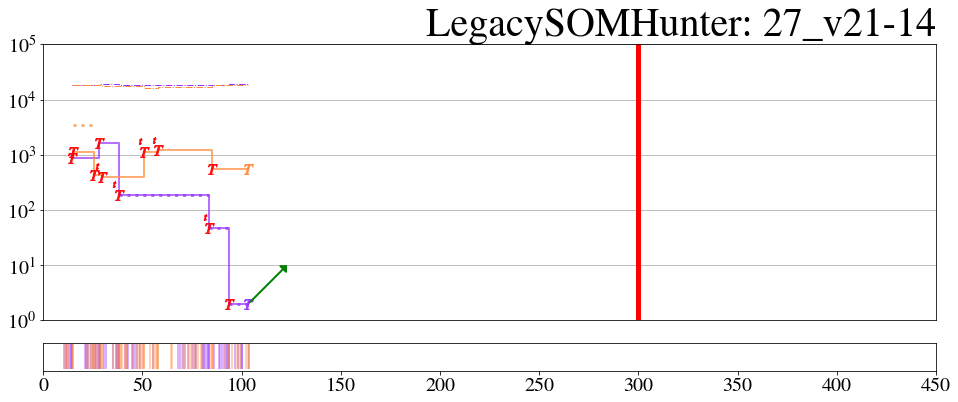

A

%%%%%%%%%%%%%%%
%%% 29_v21-15 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 29_v21-15 ---

		###!!!### 19.55 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (231, 231, 17158) -
		- ['|results|cave woman >> cave;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 36.75 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (378, 378, 17427) -
		- ['|results|cave woman >> cave;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 61.07 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (259, 281, 17953) -
		- ['|results|cave woman >> cave;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 81.40 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (622, 1154038, 10000) -

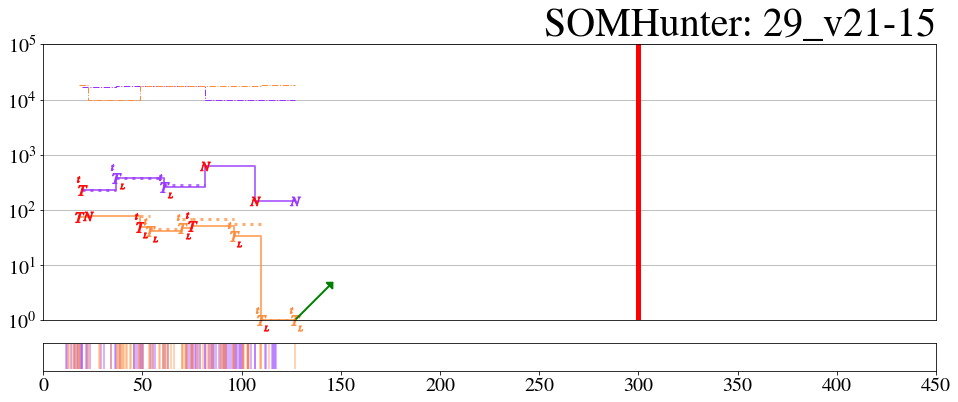

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 29_v21-15 ---

		###!!!### 39.18 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (85, 1154038, 18546) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 52.17 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (59, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 75.50 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (2, 2, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 84.11 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- [] -
		- (2, 2, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fro

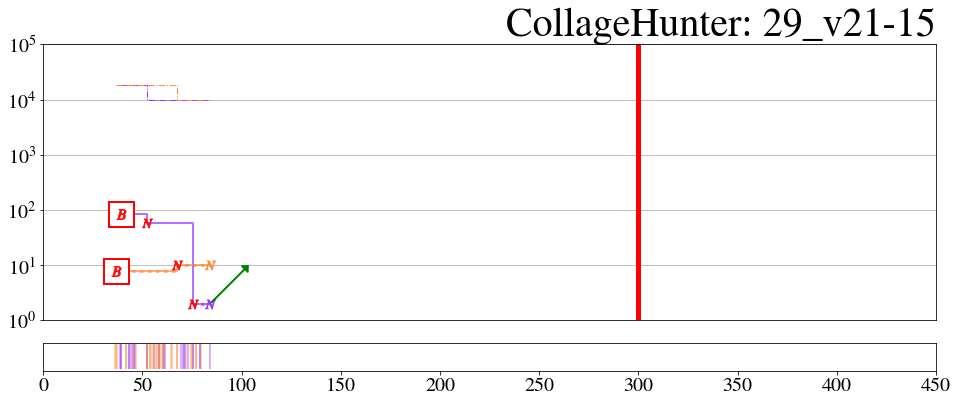

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 29_v21-15 ---

		###!!!### 18.38 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (75, 1154038, 18256) -
		- ['|results|canyon;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 28.65 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (11, 1154038, 18602) -
		- ['|results|canyon people kissing;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 70.78 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (1, 1154038, 18837) -
		- ['|results|canyon people kissing;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 98.53 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- [] -
		- (1, 1154038, 18837) -
		- ['|results|canyon peopl

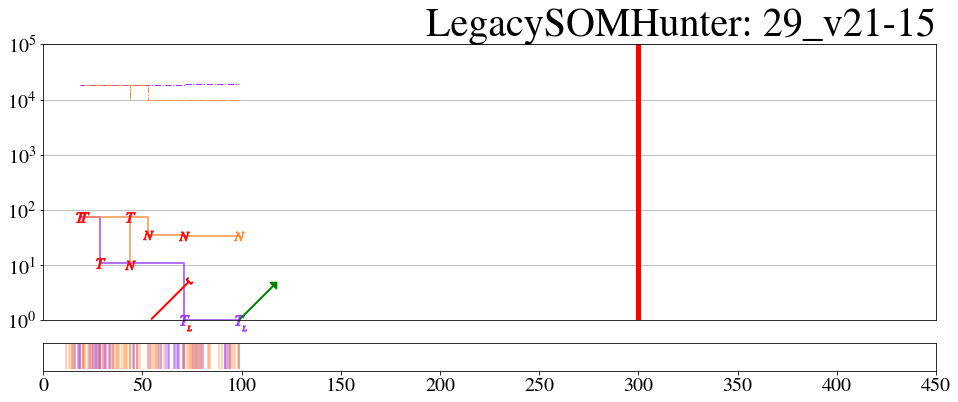

A

%%%%%%%%%%%%%%%
%%% 31_v21-16 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 31_v21-16 ---

		###!!!### 12.99 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (10, 10, 17575) -
		- ['|results|boat >> sky;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 21.07 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- [] -
		- (10, 10, 17575) -
		- ['|results|boat >> sky;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-vit ---
		--- 31_v21-16 ---

		###!!!### 20.28 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (1, 1, 17626) -
		- ['|results|boat water >> clouds mountains;fromVideoLimit=3;fromShotLimit=1;datas

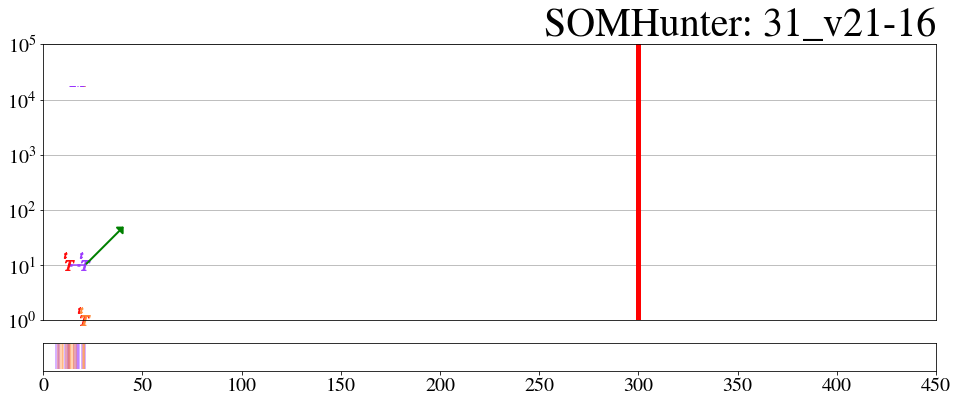

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 31_v21-16 ---

		###!!!### 43.08 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (198, 240, 18926) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 53.40 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (198, 240, 18926) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 31_v21-16 ---

		###!!!### 34.01 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (362, 362, 18880) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 48.65 ###!!!###
		

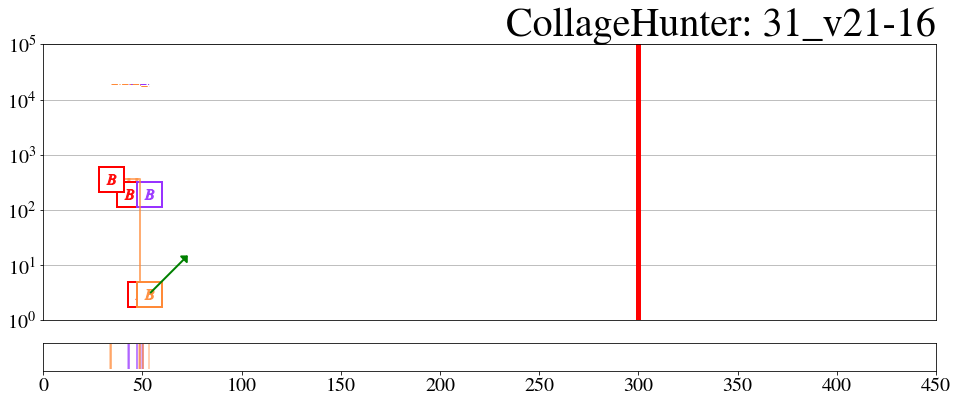

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 31_v21-16 ---

		###!!!### 14.82 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (13, 13, 18715) -
		- ['|results|boat water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 22.93 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- [] -
		- (13, 13, 18715) -
		- ['|results|boat water;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-franta-tomas ---
		--- 31_v21-16 ---

		###!!!### 15.31 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (1, 1, 17933) -
		- ['|results|boat >> mountains;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,

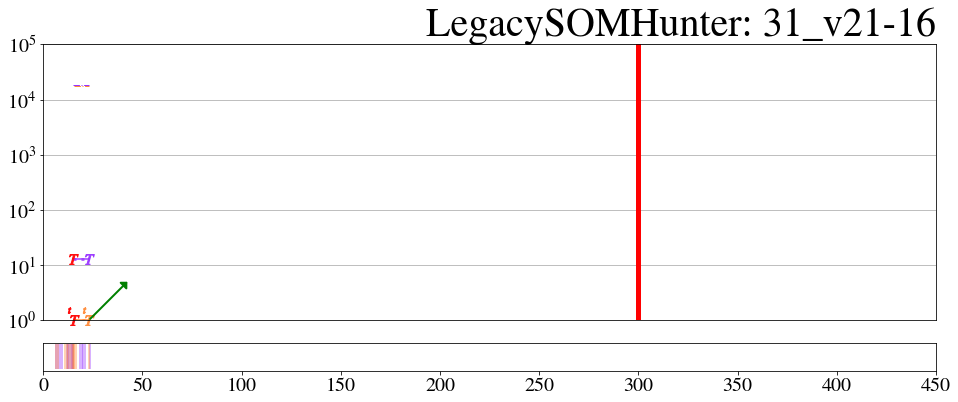


%%%%%%%%%%%%%%%
%%% 32_v21-17 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 32_v21-17 ---

		###!!!### 13.75 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (25, 1154038, 18440) -
		- ['|results|street woods;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 21.69 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (33, 263, 18328) -
		- ['|results|road woods;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 27.93 ###!!!###
		- REPORT RESULTS -
		- ['TQR'] -
		- ['TQR'] -
		- (93, 93, 18155) -
		- ['|results|road woods;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 37.52 ###!!!###
		- REPORT RESULTS -
		- ['TTQR'] -
		- ['TTQR'] -
		- (48, 48, 17449) -
		- ['|results|road woods man >> car;fr

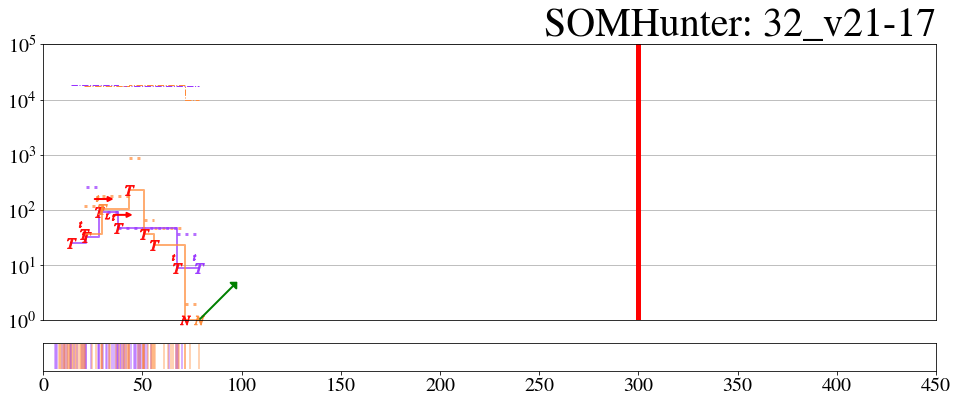

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 32_v21-17 ---

		###!!!### 61.86 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (591, 591, 18414) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 84.84 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (791, 791, 18466) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 98.60 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['LK'] -
		- (511, 511, 18500) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 109.76 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (35, 35, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPa

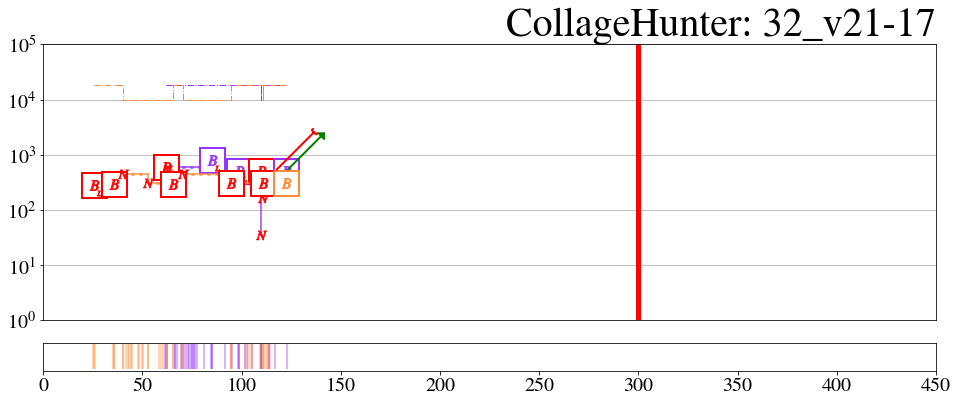

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 32_v21-17 ---

		###!!!### 15.83 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (10432, 1154038, 18449) -
		- ['|results|road man yellow stripes;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 23.39 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (117, 1154038, 18417) -
		- ['|results|road man car walking;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 31.51 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (894, 1154038, 17582) -
		- ['|results|road man car walking >> forest;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 43.26 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (395, 1154038, 17

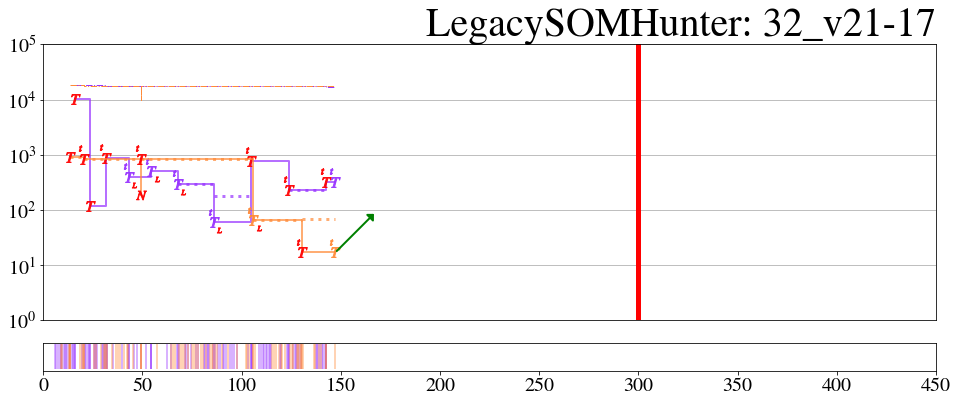

A

%%%%%%%%%%%%%%%
%%% 34_v21-18 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 34_v21-18 ---

		###!!!### 18.80 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (13, 18, 16836) -
		- ['|results|motorbike dirt road >> motor bike dirt road;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 34.78 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- [] -
		- (13, 18, 16836) -
		- ['|results|motorbike dirt road >> motor bike dirt road;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-vit ---
		--- 34_v21-18 ---

		###!!!### 21.38 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (662, 1154038, 18938) -
		- ['|results

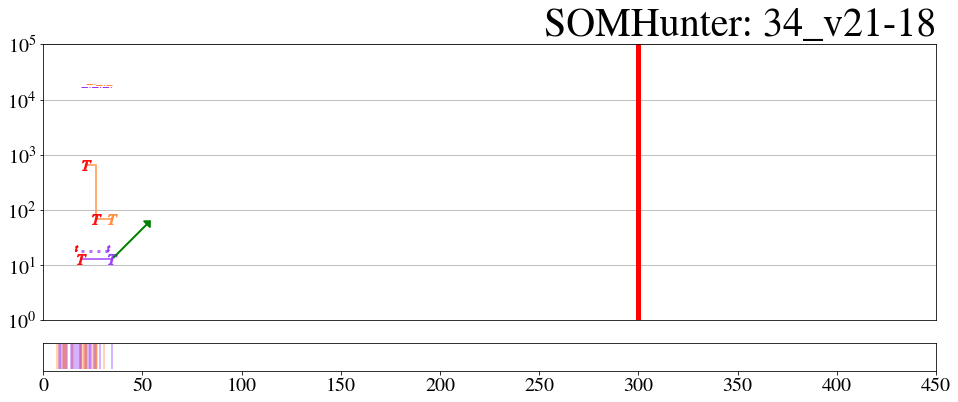

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 34_v21-18 ---

		###!!!### 47.78 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (16, 1154038, 18871) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 57.99 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (16, 1154038, 18871) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 34_v21-18 ---

		###!!!### 28.21 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (6, 1154038, 18624) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 45.92 ###!

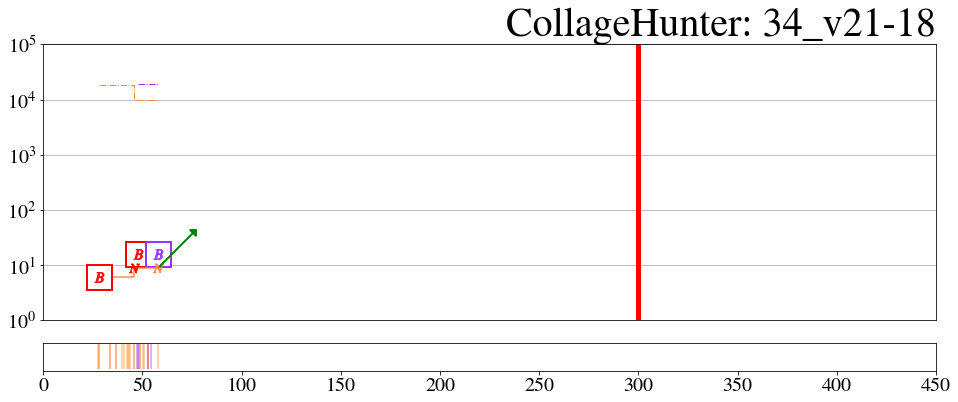

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 34_v21-18 ---

		###!!!### 22.96 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (91, 1154038, 18678) -
		- ['|results|motorcycle track;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 31.39 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (27, 1154038, 18543) -
		- ['|results|motorcycle countryside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 42.13 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (7, 1154038, 18531) -
		- ['|results|motorcycle countryside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 90.48 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (1, 1154038, 18675) -
		- ['|resu

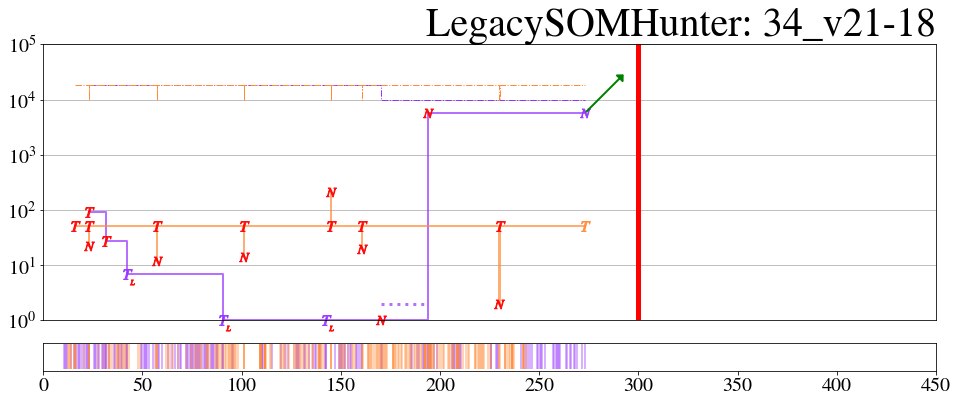


%%%%%%%%%%%%%%%
%%% 35_v21-19 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 35_v21-19 ---

		###!!!### 21.88 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (43, 1154038, 16704) -
		- ['|results|snow horizon hills >> snow horizon hills;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 138.49 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- [] -
		- (43, 1154038, 16704) -
		- ['|results|snow horizon hills >> snow horizon hills;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-vit ---
		--- 35_v21-19 ---

		###!!!### 20.92 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (92, 1154038, 18520) -
		- ['|resul

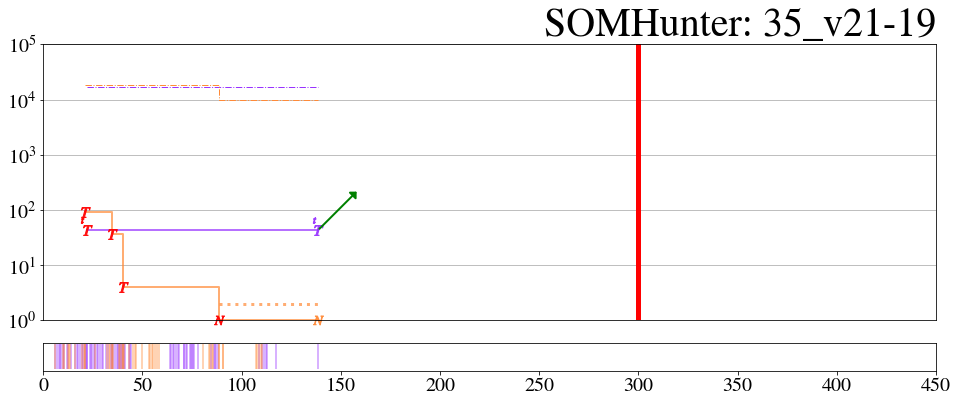

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 35_v21-19 ---

		###!!!### 45.83 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (1, 1154038, 18615) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 82.20 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- [] -
		- (1, 1154038, 18615) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 35_v21-19 ---

		###!!!### 41.67 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (196, 1154038, 18357) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 82.20 ###!

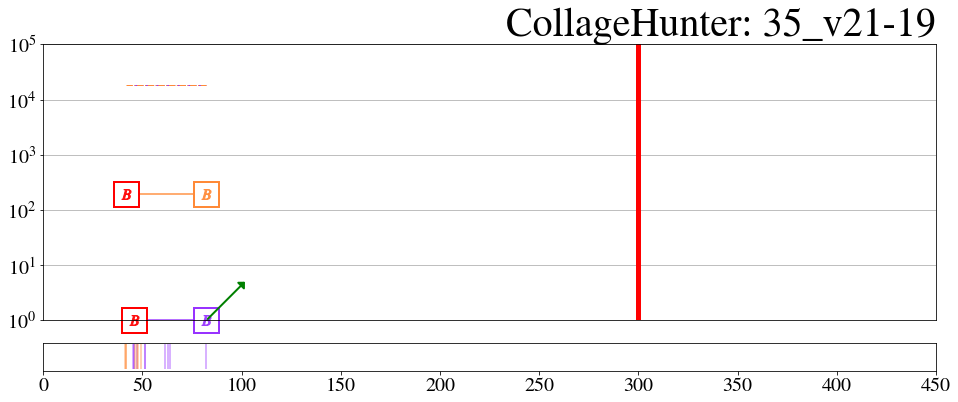

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 35_v21-19 ---

		###!!!### 24.70 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (466, 1154038, 18553) -
		- ['|results|mountains sky;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 33.06 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (89, 1154038, 17842) -
		- ['|results|mountains sky >> snow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 51.36 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (38, 1154038, 17761) -
		- ['|results|mountains sky sky >> snow;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 77.41 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TTQ'] -
		- ['LK'] -
		- (113, 1154038, 17515) -
		- ['|re

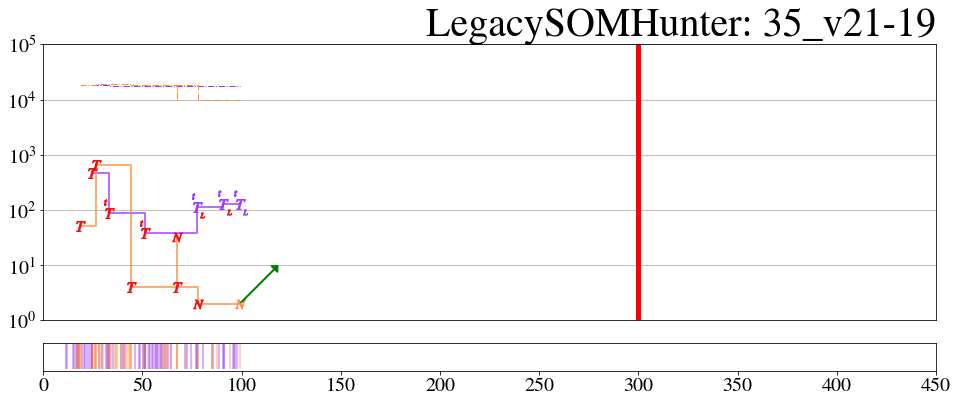


%%%%%%%%%%%%%%%
%%% 36_v21-20 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 36_v21-20 ---

		###!!!### 36.91 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (712, 1154038, 17953) -
		- ['|results|bride stairs >> wedding hall;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 48.44 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (654, 654, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 127.51 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (169, 1154038, 18271) -
		- ['|results|bride stairs >> chandelier;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 132.25 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -


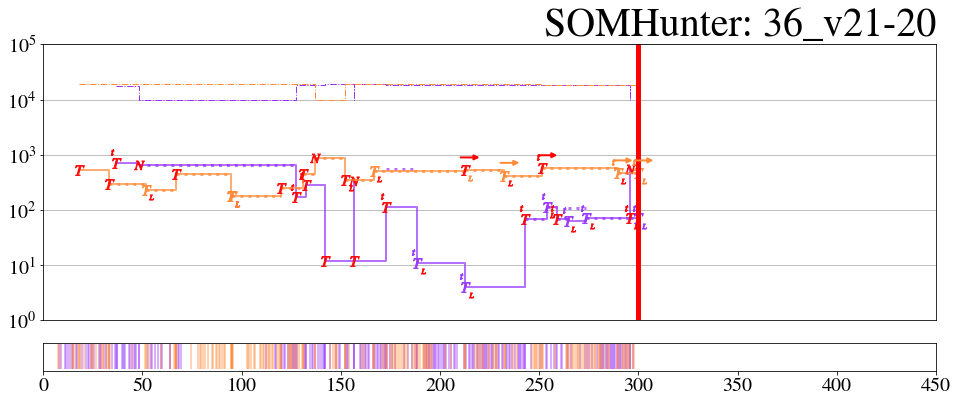

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 36_v21-20 ---

		###!!!### 42.75 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (334, 1154038, 18419) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 96.74 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (715, 1772, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 96.83 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (334, 1154038, 18419) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 122.04 ###!!!###
		- REPORT RESULTS -
		- ['NN'] -
		- ['NN'] -
		- (519, 1154038, 10000) -
		- ['|results|;showNearestNeighboursDisplay;fromVideoL

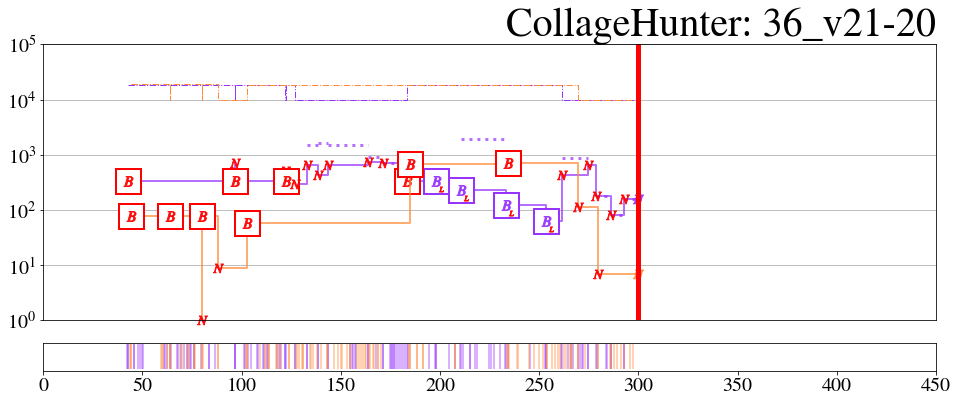

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 36_v21-20 ---

		###!!!### 16.36 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (257, 257, 18927) -
		- ['|results|bride staircase;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 39.74 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (87, 87, 18951) -
		- ['|results|bride staircase;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 45.98 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- [] -
		- (87, 87, 18951) -
		- ['|results|bride staircase;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-fran

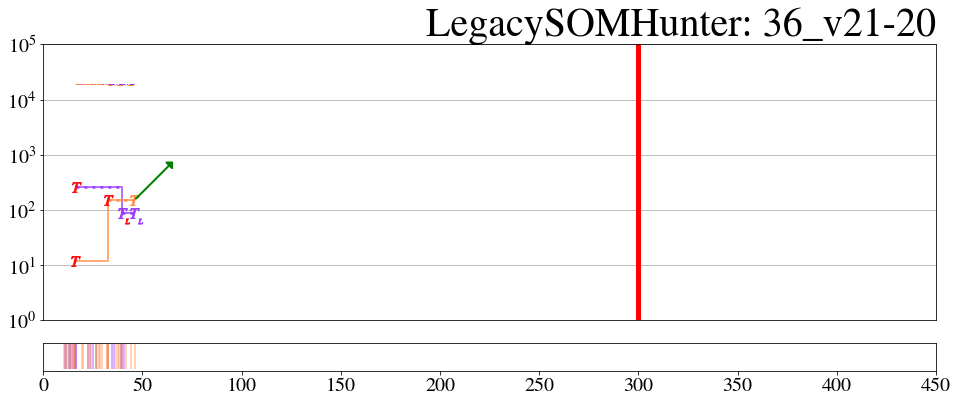

A

%%%%%%%%%%%%%%%
%%% 38_v21-21 %%%
%%%%%%%%%%%%%%%
	--- TEAM: SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 38_v21-21 ---

		###!!!### 17.99 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (179, 1154038, 19141) -
		- ['|results|drums orchestra;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 38.40 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- ['LK'] -
		- (2, 1154038, 19007) -
		- ['|results|drums orchestra church;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 53.84 ###!!!###
		- REPORT RESULTS -
		- ['LK', 'TQ'] -
		- [] -
		- (2, 1154038, 19007) -
		- ['|results|drums orchestra church;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***##########################

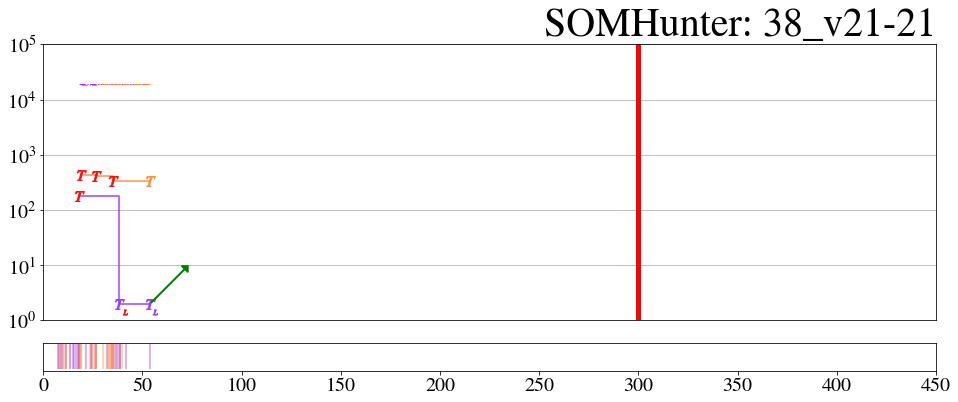

	--- TEAM: CollageHunter ---
		--- collage-jakub ---
		--- collage-premek ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-jakub ---
		--- 38_v21-21 ---

		###!!!### 70.94 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- ['CBQ', 'LK'] -
		- (1, 2, 19052) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 113.95 ###!!!###
		- REPORT RESULTS -
		- ['CBQ', 'LK'] -
		- [] -
		- (1, 2, 19052) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

***############################***
***###*** TASK COURSES ***###***
***############################***
--- CollageHunter ---
	--- collage-premek ---
		--- 38_v21-21 ---

		###!!!### 26.92 ###!!!###
		- REPORT RESULTS -
		- ['CBQ'] -
		- ['CBQ'] -
		- (781, 1154038, 19147) -
		- ['|results|;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 33.

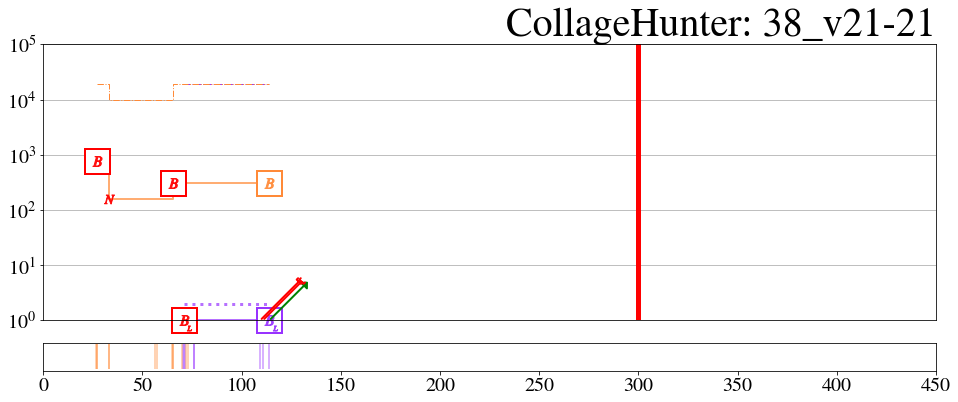

	--- TEAM: LegacySOMHunter ---
		--- legacy-tereza ---
		--- legacy-franta-tomas ---
***############################***
***###*** TASK COURSES ***###***
***############################***
--- LegacySOMHunter ---
	--- legacy-tereza ---
		--- 38_v21-21 ---

		###!!!### 11.26 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (408, 1154038, 18865) -
		- ['|results|drums;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 23.07 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (395, 1154038, 19060) -
		- ['|results|drum people;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 37.04 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- ['TQ'] -
		- (11, 1154038, 18762) -
		- ['|results|drum people yellow scarf;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 60.04 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- [] -
		- (11, 1154038, 18762) -
		- ['|results|drum people yellow scarf;fro

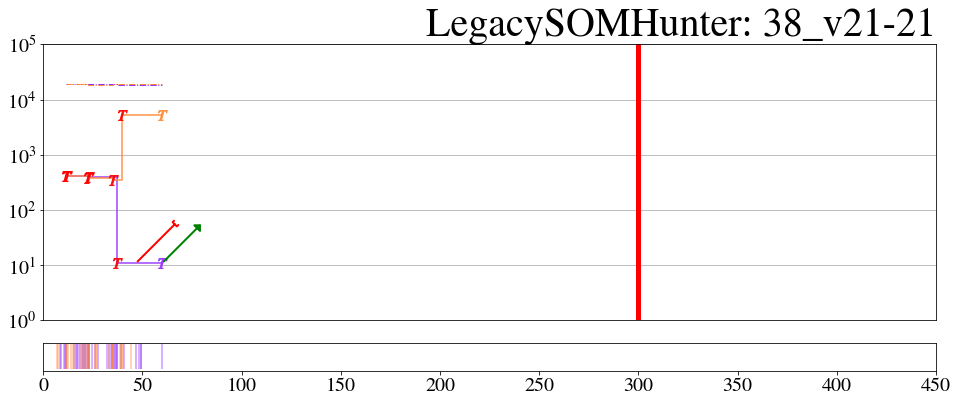

{'resetAll', 'bookmark', 'showTopScoredContextDisplay', 'like', 'submit', 'showNearestNeighboursDisplay', 'textQueryChange', 'unbookmark', 'reportResults', 'showDetailDisplay', 'scroll', 'unlike', 'rescore', 'showTopScoredDisplay', 'searchContextSwitch', 'showSomRelocationDisplay', 'showSomDisplay'}


In [8]:
#plot_timelines(vbs, tasks=["27_v21-14"])
plot_timelines(vbs, task_types=["T", "V"])


# Info queries

In [9]:
#vbs.print_task_course(["SOMHunter"], ["sh-patrik"], ["09_a21-7"])

In [10]:
vbs.print_tasks()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

#vbs.print_tasks(["01_v21-1"])

***############################***
***###*** VBS 2021 TASKS ***###***
***############################***
>>>>>>>>>>>>> STATS <<<<<<<<<<<<<<<<
Number of tasks: 38
Unique video IDs: 
88, 1162, 1939, 2034, 2224, 2464, 2519, 3085, 3317, 3331, 3870, 3885, 4035, 4178, 4225, 4316, 4888, 4979, 5146, 5531, 6228, 6246, 6561, 6827, 6979, 7116, 7421, 
>>>>>>>>>>>>> TASKS <<<<<<<<<<<<<<<<
	*** Task ***
	name: 01_v21-1
	type: V
	timestamps: (1624277458765, 1624277758765)
	times: (21-06-2021 14:10:58, 21-06-2021 14:15:58)
	text: None
	target: *** TaskTarget ***
		video_ID: 4178
		interval: (1875.0, 2300.0)




------------------------------------
	*** Task ***
	name: 02_a21-5
	type: A
	timestamps: (1624277828154, 1624278128154)
	times: (21-06-2021 14:17:08, 21-06-2021 14:22:08)
	text: Find shots of a person holding or waving a flag.
	target: None

------------------------------------
	*** Task ***
	name: 03_t21-1
	type: T
	timestamps: (1624278204021, 1624278624021)
	times: (21-06-2021 14:23:24, 21-06-2021 14:30:24)
	text: Graffity artists spraying purple outline of the letters RTH. Letters are white/green on a wall with a blueish graffity on the left. He wears a blue jacket over a green hoodie.

	target: *** TaskTarget ***
		video_ID: 3085
		interval: (7850.0, 8425.0)




------------------------------------
	*** Task ***
	name: 04_v21-2
	type: V
	timestamps: (1624278710026, 1624279010026)
	times: (21-06-2021 14:31:50, 21-06-2021 14:36:50)
	text: None
	target: *** TaskTarget ***
		video_ID: 1162
		interval: (23050.0, 23700.0)




------------------------------------
	*** Task ***
	name: 05_a21-9
	type: A
	timestamps: (1624279149067, 1624279449067)
	times: (21-06-2021 14:39:09, 21-06-2021 14:44:09)
	text: Find shots of at least one person drinking beer.
	target: None

------------------------------------
	*** Task ***
	name: 06_t21-2
	type: T
	timestamps: (1624279524639, 1624279944639)
	times: (21-06-2021 14:45:24, 21-06-2021 14:52:24)
	text: A hand opening and closing a window of a mountain hut. There are snow covered mountains outside. The weather is sunny, the shadow of the hut is visible in the snow.

	target: *** TaskTarget ***
		video_ID: 2224
		interval: (2097.9021000000002, 2337.6623400000003)




------------------------------------
	*** Task ***
	name: 07_v21-3
	type: V
	timestamps: (1624280086318, 1624280386318)
	times: (21-06-2021 14:54:46, 21-06-2021 14:59:46)
	text: None
	target: *** TaskTarget ***
		video_ID: 5146
		interval: (179.82018, 779.22078)




------------------------------------
	*** Task ***
	name: 08_t21-7
	type: T
	timestamps: (1624280613622, 1624281033622)
	times: (21-06-2021 15:03:33, 21-06-2021 15:10:33)
	text: A young man sitting outdoors and eating. He wears a dark T-shirt and silver headphones. It is evening, trees are visible behind him (out of focus).

	target: *** TaskTarget ***
		video_ID: 4316
		interval: (33326.64, 33494.472)




------------------------------------
	*** Task ***
	name: 09_a21-7
	type: A
	timestamps: (1624281095339, 1624281395339)
	times: (21-06-2021 15:11:35, 21-06-2021 15:16:35)
	text: Find shots showing a sign with text (large enough to be readable)
	target: None

------------------------------------
	*** Task ***
	name: 10_a21-8
	type: A
	timestamps: (1624283832488, 1624284132488)
	times: (21-06-2021 15:57:12, 21-06-2021 16:02:12)
	text: Find shots inside an airplane, showing at least one passenger.
	target: None

------------------------------------
	*** Task ***
	name: 11_v21-4
	type: V
	timestamps: (1624284220843, 1624284520843)
	times: (21-06-2021 16:03:40, 21-06-2021 16:08:40)
	text: None
	target: *** TaskTarget ***
		video_ID: 3317
		interval: (4450.0, 5075.0)




------------------------------------
	*** Task ***
	name: 12_t21-3
	type: T
	timestamps: (1624284561630, 1624284981630)
	times: (21-06-2021 16:09:21, 21-06-2021 16:16:21)
	text: Historic shots of a hurdle race and discus throwing. The video is in sepia tones. In the hurdle race, men run towards the camera, with bystanders on the sides.

	target: *** TaskTarget ***
		video_ID: 6228
		interval: (0.0, 389.61039)




------------------------------------
	*** Task ***
	name: 13_a21-1
	type: A
	timestamps: (1624285278073, 1624285578073)
	times: (21-06-2021 16:21:18, 21-06-2021 16:26:18)
	text: Find outdoor shots of two women walking and talking to each other.
	target: None

------------------------------------
	*** Task ***
	name: 14_t21-4
	type: T
	timestamps: (1624285646178, 1624286066178)
	times: (21-06-2021 16:27:26, 21-06-2021 16:34:26)
	text: An African man runs across a street with trees and parked cars, stops on the sidewalk and walks towards the camera. Video is black and white, in the first shots we see part of a bench. The man has dreadlocks, on the left of the sidewalk there is a low wall.

	target: *** TaskTarget ***
		video_ID: 6561
		interval: (16750.0, 17225.0)




------------------------------------
	*** Task ***
	name: 15_v21-5
	type: V
	timestamps: (1624286556757, 1624286856757)
	times: (21-06-2021 16:42:36, 21-06-2021 16:47:36)
	text: None
	target: *** TaskTarget ***
		video_ID: 3870
		interval: (4475.0, 5050.0)




------------------------------------
	*** Task ***
	name: 16_t21-5
	type: T
	timestamps: (1624286913351, 1624287333351)
	times: (21-06-2021 16:48:33, 21-06-2021 16:55:33)
	text: We see a black car approaching and stopping (shot from ground level), then a shot showing the man in the car follows. When the car stops in the first shot, we see the left wheel in focus, the rest blurred. The sitting in the car man wears a baseball cap and a jacket, the camera zooms to his face.

	target: *** TaskTarget ***
		video_ID: 7421
		interval: (768.0, 1176.0)




------------------------------------
	*** Task ***
	name: 17_v21-6
	type: V
	timestamps: (1624287415948, 1624287715948)
	times: (21-06-2021 16:56:55, 21-06-2021 17:01:55)
	text: None
	target: *** TaskTarget ***
		video_ID: 88
		interval: (7912.08792, 8421.57843)




------------------------------------
	*** Task ***
	name: 18_v21-7
	type: V
	timestamps: (1624440790581, 1624441090581)
	times: (23-06-2021 11:33:10, 23-06-2021 11:38:10)
	text: None
	target: *** TaskTarget ***
		video_ID: 4035
		interval: (8871.12888, 9380.61939)




------------------------------------
	*** Task ***
	name: 19_a21-2
	type: A
	timestamps: (1624441167899, 1624441467899)
	times: (23-06-2021 11:39:27, 23-06-2021 11:44:27)
	text: Find shots of people having their hair done.
	target: None

------------------------------------
	*** Task ***
	name: 20_v21-8
	type: V
	timestamps: (1624441541770, 1624441841770)
	times: (23-06-2021 11:45:41, 23-06-2021 11:50:41)
	text: None
	target: *** TaskTarget ***
		video_ID: 4979
		interval: (8325.0, 8800.0)




------------------------------------
	*** Task ***
	name: 21_v21-9
	type: V
	timestamps: (1624441993708, 1624442293708)
	times: (23-06-2021 11:53:13, 23-06-2021 11:58:13)
	text: None
	target: *** TaskTarget ***
		video_ID: 1939
		interval: (8012.5, 8700.0)




------------------------------------
	*** Task ***
	name: 22_v21-10
	type: V
	timestamps: (1624442363512, 1624442663512)
	times: (23-06-2021 11:59:23, 23-06-2021 12:04:23)
	text: None
	target: *** TaskTarget ***
		video_ID: 4225
		interval: (3926.07393, 4315.68432)




------------------------------------
	*** Task ***
	name: 23_v21-11
	type: V
	timestamps: (1624442760854, 1624443060854)
	times: (23-06-2021 12:06:00, 23-06-2021 12:11:00)
	text: None
	target: *** TaskTarget ***
		video_ID: 6979
		interval: (2925.072, 3332.6639999999998)




------------------------------------
	*** Task ***
	name: 24_v21-12
	type: V
	timestamps: (1624443154781, 1624443454781)
	times: (23-06-2021 12:12:34, 23-06-2021 12:17:34)
	text: None
	target: *** TaskTarget ***
		video_ID: 4888
		interval: (4975.0, 5450.0)




------------------------------------
	*** Task ***
	name: 25_v21-13
	type: V
	timestamps: (1624443516404, 1624443816404)
	times: (23-06-2021 12:18:36, 23-06-2021 12:23:36)
	text: None
	target: *** TaskTarget ***
		video_ID: 2034
		interval: (950.0, 1425.0)




------------------------------------
	*** Task ***
	name: 26_a21-3
	type: A
	timestamps: (1624443879008, 1624444179008)
	times: (23-06-2021 12:24:39, 23-06-2021 12:29:39)
	text: Find shots of a person skiing, with his/her own skis in the picture.
	target: None

------------------------------------
	*** Task ***
	name: 27_v21-14
	type: V
	timestamps: (1624444377137, 1624444677137)
	times: (23-06-2021 12:32:57, 23-06-2021 12:37:57)
	text: None
	target: *** TaskTarget ***
		video_ID: 2519
		interval: (720.0, 1170.0)




------------------------------------
	*** Task ***
	name: 28_a21-10
	type: A
	timestamps: (1624446978040, 1624447278040)
	times: (23-06-2021 13:16:18, 23-06-2021 13:21:18)
	text: Find shots of two adult men hugging each other.
	target: None

------------------------------------
	*** Task ***
	name: 29_v21-15
	type: V
	timestamps: (1624447335063, 1624447635063)
	times: (23-06-2021 13:22:15, 23-06-2021 13:27:15)
	text: None
	target: *** TaskTarget ***
		video_ID: 7116
		interval: (3386.61339, 3836.16384)




------------------------------------
	*** Task ***
	name: 30_a21-4
	type: A
	timestamps: (1624447710260, 1624448010260)
	times: (23-06-2021 13:28:30, 23-06-2021 13:33:30)
	text: Find shots of kids playing football (soccer).
	target: None

------------------------------------
	*** Task ***
	name: 31_v21-16
	type: V
	timestamps: (1624448185021, 1624448485021)
	times: (23-06-2021 13:36:25, 23-06-2021 13:41:25)
	text: None
	target: *** TaskTarget ***
		video_ID: 6246
		interval: (527.472, 839.16)




------------------------------------
	*** Task ***
	name: 32_v21-17
	type: V
	timestamps: (1624448569543, 1624448869543)
	times: (23-06-2021 13:42:49, 23-06-2021 13:47:49)
	text: None
	target: *** TaskTarget ***
		video_ID: 3331
		interval: (1198.8, 1486.512)




------------------------------------
	*** Task ***
	name: 33_a21-11
	type: A
	timestamps: (1624448946650, 1624449246650)
	times: (23-06-2021 13:49:06, 23-06-2021 13:54:06)
	text: Find shots of people skiing, shot with the camera looking into the sun (back-lit shot, possibly with lens flare).
	target: None

------------------------------------
	*** Task ***
	name: 34_v21-18
	type: V
	timestamps: (1624449356322, 1624449656322)
	times: (23-06-2021 13:55:56, 23-06-2021 14:00:56)
	text: None
	target: *** TaskTarget ***
		video_ID: 5531
		interval: (1850.0, 2175.0)




------------------------------------
	*** Task ***
	name: 35_v21-19
	type: V
	timestamps: (1624450582353, 1624450882353)
	times: (23-06-2021 14:16:22, 23-06-2021 14:21:22)
	text: None
	target: *** TaskTarget ***
		video_ID: 2464
		interval: (5825.0, 6325.0)




------------------------------------
	*** Task ***
	name: 36_v21-20
	type: V
	timestamps: (1624451061608, 1624451361608)
	times: (23-06-2021 14:24:21, 23-06-2021 14:29:21)
	text: None
	target: *** TaskTarget ***
		video_ID: 6827
		interval: (4531.464, 4891.103999999999)




------------------------------------
	*** Task ***
	name: 37_a21-6
	type: A
	timestamps: (1624451557507, 1624451857507)
	times: (23-06-2021 14:32:37, 23-06-2021 14:37:37)
	text: Find underwater shots of one or more fish.
	target: None

------------------------------------
	*** Task ***
	name: 38_v21-21
	type: V
	timestamps: (1624451948839, 1624452248839)
	times: (23-06-2021 14:39:08, 23-06-2021 14:44:08)
	text: None
	target: *** TaskTarget ***
		video_ID: 3885
		interval: (6458.541465, 6863.13687)




------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [11]:
vbs.print_tool_features()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

vbs.print_tool_features(["SOMHunter"])

***#####################################***
***###*** TOOL FEATURES & STATES  ***###***
***#####################################***
--- SOMHunter ---
	['CTQ'] -> canvas-text-query
	['TCTQ'] -> temporal-canvas-text-query
	['TQ'] -> text-query
	['TQR'] -> text-query-relocation
	['TTQ'] -> temporal-text-query
	['LK', 'TTQ'] -> like, temporal-text-query
	['TQR', 'LK', 'FDP'] -> filter-dataset-part, like, text-query-relocation
	['TQR', 'FDP'] -> filter-dataset-part, text-query-relocation
	['NN'] -> nearest-neighbours
	['TQR', 'LK'] -> like, text-query-relocation
	['TTQR'] -> temporal-text-query-relocation
	['I'] -> initial
	['LK', 'TQ'] -> like, text-query
	['LK', 'TQ', 'FDP'] -> filter-dataset-part, like, text-query
	['TQ'] -> text-query
	['LK', 'TTQR'] -> like, temporal-text-query-relocation
--- CollageHunter ---
	['CBQ'] -> canvas-bitmap-query
	['NN'] -> nearest-neighbours
	['CBQ', 'LK'] -> canvas-bitmap-query, like
--- LegacySOMHunter ---
	['TQ'] -> text-query
	['TTQ'] -> temporal-text-

In [12]:
vbs.print_task_results_arrays()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

vbs.print_task_results(["SOMHunter"], ["sh-patrik", "sh-vit"], ["09_a21-7"])

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
vbs.print_task_results()

***############################***
***###***  RESULT ARRAYS ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
_elapsed:
[14.07, 34.28, 66.44, 86.84, 102.73]
_class:
[['TQ'], ['LK', 'TQ'], ['TQ'], ['LK', 'TQ'], ['LK', 'TQ']]
_video:
[70, 39, 47, 9, 9]
_frame:
[1154038, 1154038, 102, 23, 23]

		--------------------

_elapsed:
[14.61, 24.02, 57.8, 88.56, 170.08, 218.6, 273.04, 300.0]
_class:
[['TQ'], ['LK', 'TQ', 'FDP'], ['LK', 'TQ', 'FDP'], ['LK', 'TQ', 'FDP'], ['TQR'], ['TQ'], ['TQR'], ['TQR']]
_video:
[None, None, None, None, None, None, None, None]
_frame:
[None, None, None, None, None, None, None, None]

		--------------------

_elapsed:
[10.79, 20.38, 137.81, 243.9, 262.81, 269.78, 321.98]
_class:
[['TQ'], ['LK', 'TQ'], ['LK', 'TQ'], ['TQ'], ['LK', 'TQ'], ['NN'], ['NN']]
_video:
[42, 43, 40, 26, 57, 57, 57]
_frame:
[1154038, 1154038, 1154038, 1154038, 1154038, 1154038, 1154038]

		--------------------

_elapsed:
[26.43, 42.02, 95.15, 112.53, 134.85, 1

In [13]:
#
# Print results from the given interval
#
# vbs.print_results("SOMHunter", "sh-patrik", 1624281095339, 1624281395339)
# vbs.print_results("SOMHunter", "sh-vit", 1624281095339, 1624281395339)


In [14]:
#
# Print submits for each task
#
vbs.print_task_submits_arrays()
vbs.print_task_submits()

***############################***
***###*** SUBMITS ARRAYS ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 01_v21-1 ---
_elapsed:
[102.73]
_class:
['T']

		--------------------

		--- 02_a21-5 ---
_elapsed:
[32.12, 37.52, 61.74, 69.92, 78.31, 78.39, 95.31, 110.01, 122.22, 167.37, 178.42, 221.74, 231.24, 248.74, 265.98, 285.19, 292.95]
_class:
['W', 'W', 'W', 'F', 'T', 'W', 'F', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'T', 'T']

		--------------------

		--- 03_t21-1 ---
_elapsed:
[321.98]
_class:
['T']

		--------------------

		--- 04_v21-2 ---
_elapsed:
[]
_class:
[]

		--------------------

		--- 05_a21-9 ---
_elapsed:
[34.2, 64.67, 71.11, 121.38, 122.08, 134.84, 139.23, 144.93, 155.12, 158.41, 164.27, 171.84, 194.71, 201.37, 212.46, 221.99, 246.68, 257.51, 282.58]
_class:
['T', 'T', 'W', 'W', 'W', 'T', 'W', 'T', 'T', 'T', 'W', 'T', 'W', 'W', 'W', 'W', 'W', 'W', 'W']

		--------------------

		--- 06_t21-2 ---
_elapsed:
[]
_class:
[]

		-----

In [15]:
vbs.print_task_course(["SOMHunter"], ["sh-patrik"], ["27_v21-14"], events=["r"])


***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 27_v21-14 ---

		###!!!### 23.98 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (343, 1154038, 17858) -
		- ['|results|skateboard >> train inside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 34.08 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (336, 1154038, 17907) -
		- ['|results|skateboard skateboard >> train inside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 49.71 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (869, 1154038, 17657) -
		- ['|results|skateboard graffiti >> train inside;fromVideoLimit=3;fromShotLimit=1;datasetPartsFilter=true,true,;'] -

		###!!!### 57.12 ###!!!###
		- REPORT RESULTS -
		- ['TTQ'] -
		- ['TTQ'] -
		- (343, 1154038, 17858) -
		- ['|results|skateboard >> train inside;fromVideoLimit=3;fromSho

In [38]:

f1 = config.out_dir("relevance")+"/relevance-feedback-transitions-from-nonliked.csv"
f2 = config.out_dir("relevance")+"/relevance-feedback-transitions-from-liked.csv"
f3 = config.out_dir("relevance")+"/relevance-feedback-transitions-all.csv"
x = vbs.get_relevance_feedback_transitions(all=True, 
    file=f1, file2=f2, file_all=f3
    )